# Dynamics of a mixture of mesogens and SW nanoparticles 
2021-08-01 Version 1.5

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math

In [2]:
# Define parameters for the SW free energy, at selected values of lambda, 
# as given by Sastre et al. https://doi.org/10.1080/00268976.2017.1392051

# Matrix B collects constants for lambda >= 1.1, where
# A1 = b0 rho* + b1 rho*^2 + b2 rho*^3.
#    b0,     b1,       b2           lambda
B=np.array([[-0.74484,-0.382173,-1.63313],   # 1.1
   [-1.51817,-1.58568,-1.40168],    # 1.2
   [-2.40494,-3.04343,-1.16285],    # 1.3
   [-3.46854,-4.36238,1.46006],     # 1.4
   [-4.74229,-5.34853,3.10155],     # 1.5
   [-6.24987,-5.88535,4.48369],     # 1.6
   [-8.01193,-5.8906,5.34814],      # 1.7
   [-10.0523,-5.27555,5.38749]] )    # 1.8

In [3]:
# For lambda = 1.1, A2 = a0 rho* + a1 rho*^2 + a2 rho*^3
a0=-0.315714
a1=-0.405783
a2=0.4394

# Matrix A collects constants for cases lambda> 1.1, 
# when A2 = g2 rho* exp(-h2 rho*^2) + f2 tanh( c2 rho*)  
#  g2,        h2,     f2,        c2 
A=np.array( [[0,0,0,0],
   [-0.754123,1.54113,0,0],                # lambda = 1.20
   [-0.400299,4.81518,-0.221092,3.42486],  # lambda = 1.30
   [-0.311957,9.62637,-0.275382,4.80383],  # lambda = 1.40
   [-0.301985,12.7563,-0.305239,6.10676],  # lambda = 1.50
   [-0.242938,10.8684,-0.333435,7.67705],  # lambda = 1.60
   [-0.310091,16.5368,-0.376464,8.31355],  # lambda = 1.70
   [0.385677,1.98941,-0.539128,8.40071]])   # lambda = 1.80, WARNING g2 was (-) in Ref. 

## Free energy terms and derivatives for the SW fluid

### Hard sphere aHS

In [4]:
# We use as our scaled variable c, with  rho* = phi c.
# Parameter phi = phi=|r|*sigma**3/alpha. 
def aHS(c,phi):
    rho = phi*c
    eta = math.pi/6.0 * rho
    resultado= (4*eta - 3*eta**2)/(1-eta)**2
    return resultado

# derivative of aHS with respect to eta
def daHS(c,phi):
    rho = phi*c
    eta = math.pi/6.0 * rho
    resultado=(2*(-eta+ 2))/(1-eta)**3
    return resultado

### Free-energy perturbation term to the first order in beta 

In [5]:
# Free energy perturbation A1
def A1(c,phi,Lambda):
    rho = phi*c
    resultado=B[Lambda-1][0]*rho + B[Lambda-1][1]*rho**2 + B[Lambda-1][2]*rho**3
    return resultado

# Derivative of A1 with respect to rho*
def dA1(c,phi,Lambda):
    rho = phi*c
    resultado=B[Lambda-1][0]+2*B[Lambda-1][1]*rho + 3*B[Lambda-1][2]*rho**2
    return resultado

### Free-energy perturbation term to the second order in beta 

In [6]:
# Free energy perturbation A2 
def A2(c,phi,Lambda):
    rho = phi*c    
    if Lambda==1:
        resultado= a0*rho + a1*rho**2 + a2*rho**3
    else:
        resultado=A[Lambda-1][0]*rho*math.exp(-A[Lambda-1][1]*rho**2) + A[Lambda-1][2]*math.tanh(A[Lambda-1][3]*rho)
    return resultado

# Derivative of A2 with respect to rho*
def dA2(c,phi,Lambda):
    rho = phi*c
    if Lambda==1:
        resultado=a0 + 2*a1*rho + 3*a2*rho**2
    else:
        resultado=((A[Lambda-1][0])*math.exp(-(A[Lambda-1][1])*rho**2))*(1- 2*((A[Lambda-1][1])*rho**2) +
                     (A[Lambda-1][3])*(A[Lambda-1][2])*1/(math.cosh((A[Lambda-1][3])*rho))**2) 
    return resultado

### Total free energy a_SW = A_SW/(N k T) 

In [7]:
def aSW(c,phi,Lambda,T):
    resultado= aHS(c,phi) + (1/T)*A1(c,phi,Lambda) + (1/T)**2*A2(c,phi,Lambda)
    return resultado

## Reduced chemical potential for the SW

In [8]:
# Reduced chemical potential mu* = mu/mu_HS 
def mustar(c,phi,Lambda,T):
    rho = phi*c
    resultado= (3/(4*math.pi))*((aSW(c,phi,Lambda,T)/rho) + (math.pi/6)*daHS(c,phi) + (1/T)*dA1(c,phi,Lambda) + ((1/T)**2)*dA2(c,phi,Lambda))
    return resultado

## Auxiliar field inside the laplacian operator (in the dynamical equation for c)

In [9]:
# inlaplacian = c mu* + alpha' s^2, which is what is inside the Laplacian operator in the 
# dynamical equation for the conserved variable c
def inlaplacian(c,phi,Lambda,T,alphap,s,N):
# DEBUG
#     print("inlaplacian::")
#     print("inlaplacian::input: <c>=",             c.mean(), "+/-",           c.std())
    
    mu_estrella= np.full((N,N), 0.000)  # CAREFUL mu_estrella = c is an alias, not a copy, of the object "c"
    
    for i in np.arange(N):
        for j in np.arange(N):
            mu_estrella[i][j] = mustar(c[i][j],phi,Lambda,T)
            
    resultado= c* mu_estrella + alphap * (s**2)  

# DEBUG
#     print("inlaplacian::out: <c>=", c.mean(), "+/-", c.std())
#     print("inlaplacian::out: <mu*>=", mu_estrella.mean(), "+/-", mu_estrella.std())
#     print("inlaplacian::out: <res>=",   resultado.mean(), "+/-",   resultado.std())
    
    return resultado

## Finite difference operations

In [10]:
# Laplacian operator in 2D using finite differences.
def laplacian2D(Z,dx):

    center  = Z[1:-1, 1:-1]
    
    #w toma desde la primer fila hasta la antepenúltima [] y desde segunda columna hasta la penúltima []
    w   = Z[0:-2, 1:-1]
    
    #e toma desde tercer fila hasta la última [] y desde segunda columna hasta la penúltima []
    e   = Z[2:  , 1:-1]   
    
    #n toma desde la  fila 1 hasta la penúltima [] y desde la columna 2 hasta la última []
    n   = Z[1:-1, 2:  ]
    
    #s toma desde la  fila 1 hasta la penúltima [] y desde la primera hasta la antepenúltima []
    s   = Z[1:-1, 0:-2]
    
    #ne toma desde la  fila 2 hasta la última [] y desde la tercera hasta la última []
    ne  = Z[2:  , 2:  ]
    
    #ne toma desde la  primera hasta la antepenúltima [] y desde la tercera hasta la última []
    nw  = Z[0:-2, 2:  ]
    
    #se toma desde la  tercera hasta la última [] y desde la primera hasta la antepenúltima []
    se  = Z[2:, 0:-2]
    
    #sw toma desde la  primera hasta la antepenúltima [] y desde la primera hasta la antepenúltima []
    sw  = Z[0:-2, 0:-2]
    
    # Weights for the different contributions
    dif2 = (w+e+n+s)/6.0 + (ne+nw+se+sw)/12.0 
    dif2 = dif2 - center
    
    # Scale by grid size squared and return.
    dif2 = dif2/dx**2 
       
    return dif2

In [11]:
# Apply periodic boundary conditions             
def PBC(Z):
    # Fill two buffer columns     
    Z[ 0,:] = Z[-2,:]    # Fill column  0 from column -2          
    Z[-1,:] = Z[ 1,:]    # Fill column -1 from column  1          
    
    # Fill two buffer rows
    Z[:, 0] = Z[:,-2]   # fill row  0 from row -2   
    Z[:,-1] = Z[:, 1]   # fill row -1 from row  1
   
    # Fill four buffer corners
    Z[0,0]   = Z[-2,-2]
    Z[0,-1]  = Z[-2, 1]
    Z[-1,0]  = Z[ 1,-2]
    Z[-1,-1] = Z[ 1, 1]

    
    return Z

In [12]:
# Apply plane-wave perturbations to a given field
def perturba(field, k, A):      # field is an array, k a wavenumber, A the perturbation amplitude
    for x in range(len(field)):
        for y in range(len(field)):
            field[x, y] += A*np.sin(k*float(y))     
            field[x, y] += A*np.sin(k*float(x))
    return field

In [13]:
# Advance the fields using the dynamics for one time step
def solve_dynamics(c,phi,Lambda,T,alphap,s,N,dx,dt,time_step,R,r):
    
    mu_mean, sigma_stdev = 0, 0.0001 # mean and standard deviation
    thermal_s = np.random.normal(mu_mean, sigma_stdev, (L,L))
    thermal_c = np.random.normal(mu_mean, sigma_stdev, (L,L))
    
    
    # DEBUG:
    #print("solve_dynamics::time_step=",time_step)
    # print("solve_dynamics::input: <c>=", c.mean(), "+/-", c.std())                 
    #
    # For dilute HS:
    # auxHS = c + alphap * s**2 
    
    # For SW:
    auxSW = inlaplacian(c,phi,Lambda,T,alphap,s,N)
        
    #nabla2_aux almacena laplaciano de aux
    nabla2_aux = laplacian2D(auxSW,dx)
    nabla2_s   = laplacian2D(s, dx)
        
    #parámetro de orden y concentracion en el centro
    sc = s[1:-1,1:-1]
    cc = c[1:-1,1:-1]
        
    #Ecuaciones no lineales, se hace un incremento en el tiempo
    s[1:-1,1:-1] = sc + dt * (nabla2_s - r * sc - sc**3 - sc * cc)  + thermal_s
    c[1:-1,1:-1] = cc + dt * R * nabla2_aux + thermal_c
    
    #s[1:-1,1:-1] = sc + dt * (nabla2_s - r * sc - sc**3 - sc * cc)  
    #c[1:-1,1:-1] = cc + dt * R * nabla2_aux   

    #se aplican condiciones periodicas en la frontera tanto en s como en c
    for x in (s, c):
        PBC(x)
    
    # DEBUG
#     print("solve_dynamics::<auxSW>=", auxSW.mean(), "+/-", auxSW.std())         
#     print("solve_dynamics::<auxHS>=", auxHS.mean(), "+/-", auxHS.std())
#     print("solve_dynamics::<nabla2_aux>=", nabla2_aux.mean(), "+/-", nabla2_aux.std())  
#     print("solve_dynamics::out: <c>=", c.mean(), "+/-", c.std())                 


## Output functions

In [38]:
# Save s and c fields to files 
def save_fields(s, c, step, nb):
    LC_file = "matrix" + "_s_" + str(step) + "_nb_" + str(nb) + ".txt"
    np.savetxt(LC_file, s, delimiter="\t")
    
    NPs_file = "matrix" + "_c_" + str(step) + "_nb_" + str(nb) + ".vtk"
    np.savetxt(NPs_file, c, delimiter="\t")

In [39]:
# Plot the 2D arrays, using grayscale for c and "seismic" colormap for s
def plot_fields_in_2D(s,c,i):
    
    plt.figure(figsize=(10, 3.5))

    plt.subplot(1, 2, 1)
    plt.imshow(c[1:-1,1:-1], cmap=plt.cm.gray)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(s[1:-1,1:-1], cmap=plt.cm.seismic)
    plt.colorbar()
    
    plt.savefig('fields_step_{}.png'.format(i))
    plt.show()

In [40]:
# Plot 1D profiles of c and s, using black for c and red for s
def plot_fields_in_1D(s,c,i):
    plt.figure(figsize=(10, 3.5))

    plt.subplot(1, 2, 1)
    plt.plot(c[1:-1,1:-1], "k")  # k means blacK


    plt.subplot(1, 2, 2)
    plt.plot(s[1:-1,1:-1], "r")  # r means Red
    
    plt.savefig('profile_fields_step_{}.png'.format(i))    
    plt.show()

# From isotropic to nematic

## Initialize the program

In [41]:
# Square-Well parameters
Lambda=1      # integer selector: lambda_SW = 1 + Lambda/10 (for instance, Lambda = 1 -> lambda_SW = 1.1)
T= 0.90        # reduced temperatura T* = (k T)/epsilon 

# Initial conditions
n_wavelengths = 2 # n_wavelengths es el número de longitudes de onda que caben en la caja, use only powers of two

c0= 0.050
s0= 0.001
Ampl = 0.001 # Ampl es la amplitud de la perturbación


# Time steps
nTimeSteps   =  100  # total number of time steps to run 
print_period =  10  # number of time steps between program printouts


# Parameters for the scaled dynamical equations 
r = -1.0      # temperature control parameter sign, sgn(r) = sgn(T-Tc)
R = 10.0      # Reduced diffusivity, R
alphap=0.05  # Reduced coupling parameter, alpha' 
phi=1         # scaling factor, rho* = phi c

# Finite differences grid parameters
L = 256    # Physical spatial size 
N = L+2   # Augmented grid size with two extra points for PBC buffers
nb = 1    # numero de bloques (quizás nb por notebook), el número de veces que se repite una iteración
dx = 1.0      # pixel size
dt = 0.01     # time step

T_total = nTimeSteps*dt  # Total simulation time

the wavenumber k= 0.04908738521234052
c.mean = 0.0500 s.mean = 0.0010
c.min  = 0.0480  s.min = -0.0010
c.max  = 0.0520  s.max = 0.0030


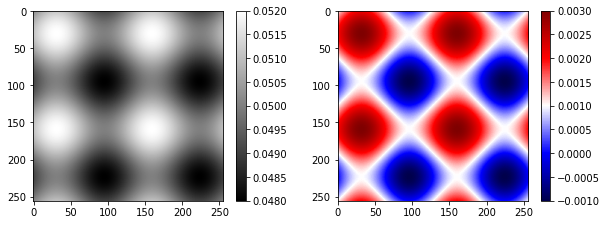

<class 'numpy.ndarray'>


In [48]:
# Initial conditions for c and s start as homogenoeus fields
for block in range(1, nb+1):
    #Se define la matriz c y s y se llenan con las condiciones iniciales
    c = np.full((N,N), c0)
    s = np.full((N,N), s0) # elige este si vas de transición isótropo a nemático

# Calculate the wavelength and the wavenumber from size L and number of wavelengths in it
lambd = L//n_wavelengths #  CAREFUL: // is the integer division operator
k = 2*np.pi/lambd # k=2pi/lambda is the wavenumber
print('the wavenumber k=',k)

# Apply plane-wave perturbations to s and c
for field in (s,c):
    perturba(field, k, Ampl)
    
# Print out statistics and plots of c and s to diagnose initial conditions
print("c.mean = {:.4f} s.mean = {:.4f}" .format(c.mean(), s.mean()))
print("c.min  = {:.4f}  s.min = {:.4f}" .format(c.min(), s.min()))
print("c.max  = {:.4f}  s.max = {:.4f}" .format(c.max(), s.max()))

# Plot s and c in 2D and 1D to diagnose initial conditions
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.imshow(c[1:-1,1:-1], cmap=plt.cm.gray)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(s[1:-1,1:-1], cmap=plt.cm.seismic)
plt.colorbar()
plt.savefig('fields_step_0.png')
plt.show()

#plot_fields_in_1D(s, c, i)



# Export figures of initial conditions

#dir = os.chdir('/home/erick/Desktop/pruebas/campo_C')
#plt.imshow(c, cmap=plt.cm.gray)
#plt.colorbar()
#plt.savefig('imagen0.png')
#plt.show()

#dir = os.chdir('/home/erick/Desktop/pruebas/Campo_S')
#plt.imshow(s, cmap=plt.cm.seismic)
#plt.colorbar()
#plt.savefig('imagen0.png')


In [49]:
# Save initial conditions to files
NPs_file = "matrix" + "_c_" + str(0)+ "_nb_" + str(nb) + ".vtk"
np.savetxt(NPs_file, c, delimiter="\t")
print(type(c))

<class 'numpy.ndarray'>


## Solve the dynamics

Program will run nTimeSteps:  10100
Print results each print_period steps:  100
Total simulation time at the end: 101.0
Temperature: = 0.900
SW range lambda  = 1.100
wavenumber k = 0.012
wavelength = 512.000
 
time_step= 100
Tiempo CPU en segundos: 924.14
c.mean = 0.0500 s.mean = 0.0026
c.min  = 0.0447  s.min = -0.0066
c.max  = 0.0553  s.max = 0.0115


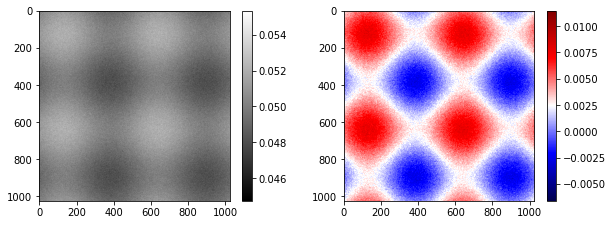

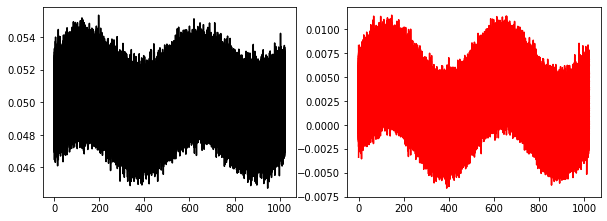

max_region_c: 0.05512346937118544 , max_region_s: 0.011404585173134816
min_region_c: 0.044891437582626106 , min_region_s: -0.006620510645532517
amplitude_c: 0.005116015894279666 , amplitude_s: 0.009012547909333667
 
time_step= 200
Tiempo CPU en segundos: 1840.30
c.mean = 0.0500 s.mean = 0.0066
c.min  = 0.0438  s.min = -0.0141
c.max  = 0.0558  s.max = 0.0263


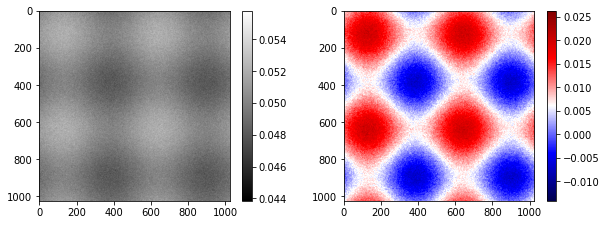

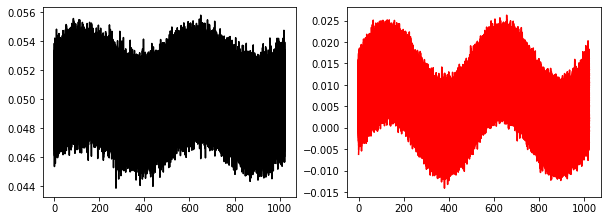

max_region_c: 0.05580804439012301 , max_region_s: 0.02628081182346216
min_region_c: 0.04384780117308714 , min_region_s: -0.014109381157817666
amplitude_c: 0.005980121608517935 , amplitude_s: 0.020195096490639913
 
time_step= 300
Tiempo CPU en segundos: 2751.10
c.mean = 0.0500 s.mean = 0.0170
c.min  = 0.0434  s.min = -0.0288
c.max  = 0.0563  s.max = 0.0615


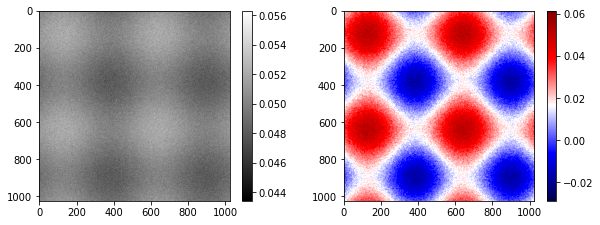

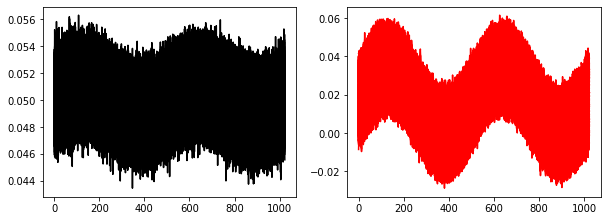

max_region_c: 0.05596789943902729 , max_region_s: 0.061528619768265624
min_region_c: 0.0434339087625325 , min_region_s: -0.028796982863667313
amplitude_c: 0.006266995338247393 , amplitude_s: 0.04516280131596647
 
time_step= 400
Tiempo CPU en segundos: 3659.30
c.mean = 0.0500 s.mean = 0.0435
c.min  = 0.0437  s.min = -0.0677
c.max  = 0.0575  s.max = 0.1488


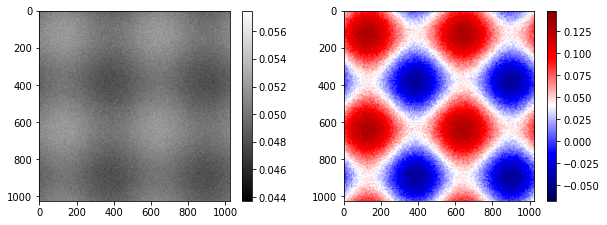

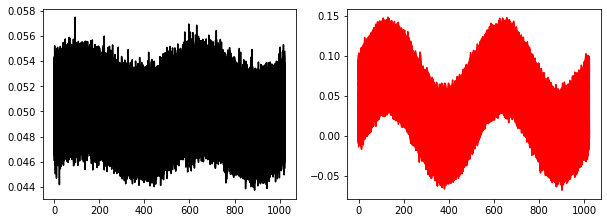

max_region_c: 0.05695618586247246 , max_region_s: 0.14821203067187566
min_region_c: 0.04400051608144017 , min_region_s: -0.06624313711532612
amplitude_c: 0.006477834890516145 , amplitude_s: 0.10722758389360089
 
time_step= 500
Tiempo CPU en segundos: 4562.87
c.mean = 0.0500 s.mean = 0.1094
c.min  = 0.0430  s.min = -0.1649
c.max  = 0.0566  s.max = 0.3518


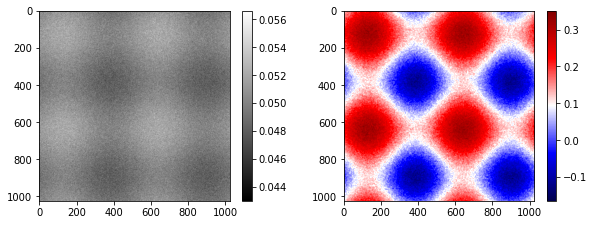

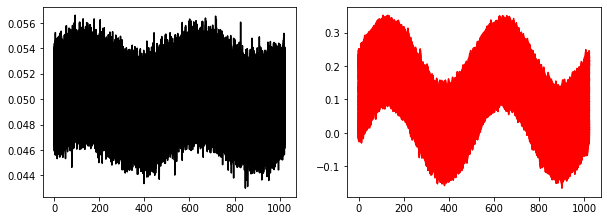

max_region_c: 0.05655116365287616 , max_region_s: 0.3504181369990365
min_region_c: 0.043344466152390966 , min_region_s: -0.1572446047166997
amplitude_c: 0.006603348750242596 , amplitude_s: 0.2538313708578681
 
time_step= 600
Tiempo CPU en segundos: 5516.95
c.mean = 0.0500 s.mean = 0.2509
c.min  = 0.0433  s.min = -0.3843
c.max  = 0.0569  s.max = 0.6835


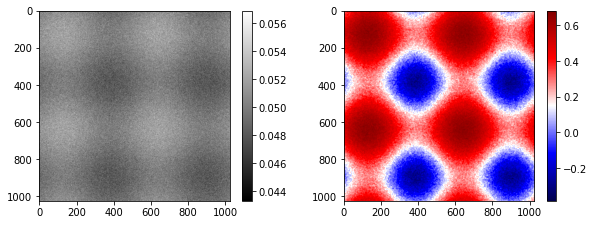

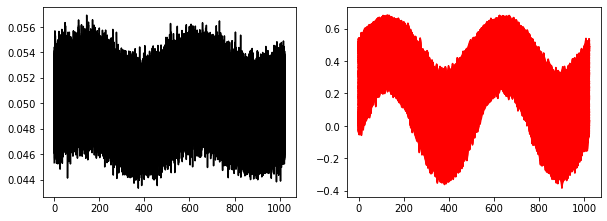

max_region_c: 0.056470019650660584 , max_region_s: 0.6824453965768266
min_region_c: 0.04332943401284248 , min_region_s: -0.3621885447422912
amplitude_c: 0.0065702928189090536 , amplitude_s: 0.5223169706595588
 
time_step= 700
Tiempo CPU en segundos: 6464.90
c.mean = 0.0500 s.mean = 0.4408
c.min  = 0.0431  s.min = -0.7161
c.max  = 0.0586  s.max = 0.9071


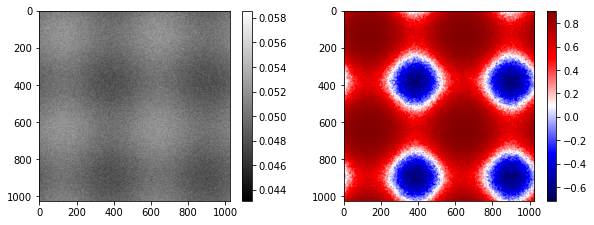

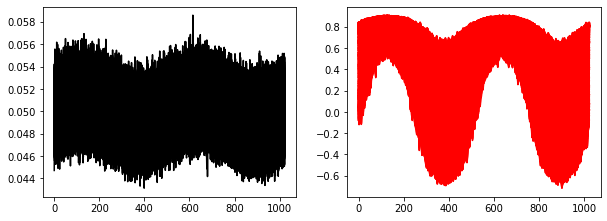

max_region_c: 0.05859451725739043 , max_region_s: 0.9056517563682281
min_region_c: 0.04311078048787337 , min_region_s: -0.6930290986669586
amplitude_c: 0.0077418683847585296 , amplitude_s: 0.7993404275175934
 
time_step= 800
Tiempo CPU en segundos: 7361.14
c.mean = 0.0500 s.mean = 0.5623
c.min  = 0.0426  s.min = -0.9178
c.max  = 0.0573  s.max = 0.9639


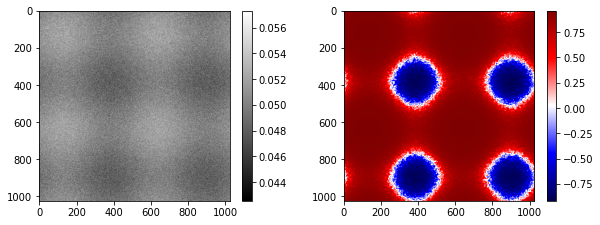

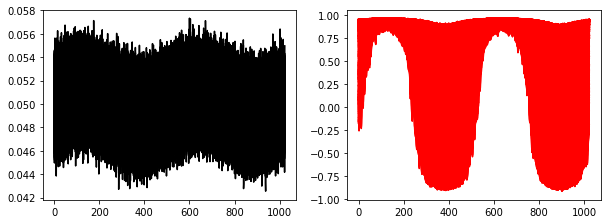

max_region_c: 0.05733272981524581 , max_region_s: 0.9636393337544146
min_region_c: 0.04271452197634845 , min_region_s: -0.9101576396849557
amplitude_c: 0.007309103919448678 , amplitude_s: 0.9368984867196851
 
time_step= 900
Tiempo CPU en segundos: 8267.24
c.mean = 0.0500 s.mean = 0.6019
c.min  = 0.0415  s.min = -0.9674
c.max  = 0.0577  s.max = 0.9743


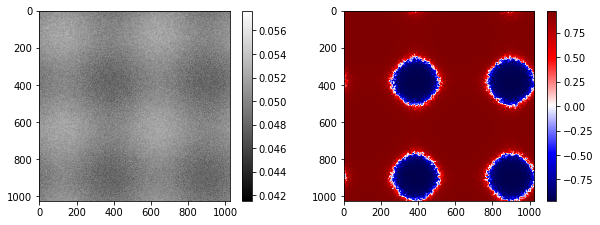

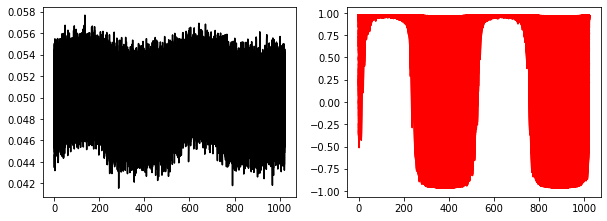

max_region_c: 0.05692886426676054 , max_region_s: 0.9740834460636665
min_region_c: 0.041549935180198366 , min_region_s: -0.9665695137035543
amplitude_c: 0.007689464543281087 , amplitude_s: 0.9703264798836104
 
time_step= 1000
Tiempo CPU en segundos: 9163.23
c.mean = 0.0500 s.mean = 0.6108
c.min  = 0.0383  s.min = -0.9763
c.max  = 0.0638  s.max = 0.9763


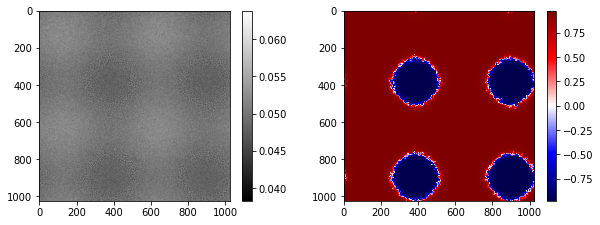

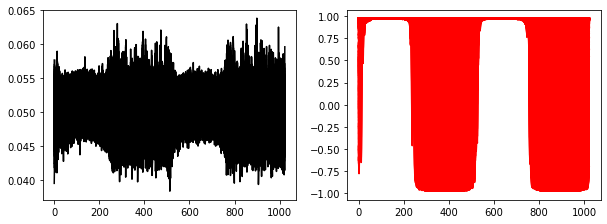

max_region_c: 0.06303237677714425 , max_region_s: 0.9762310708800056
min_region_c: 0.03830749746111138 , min_region_s: -0.9763063434726599
amplitude_c: 0.012362439658016436 , amplitude_s: 0.9762687071763327
 
time_step= 1100
Tiempo CPU en segundos: 10058.90
c.mean = 0.0500 s.mean = 0.6125
c.min  = 0.0334  s.min = -0.9780
c.max  = 0.0763  s.max = 0.9774


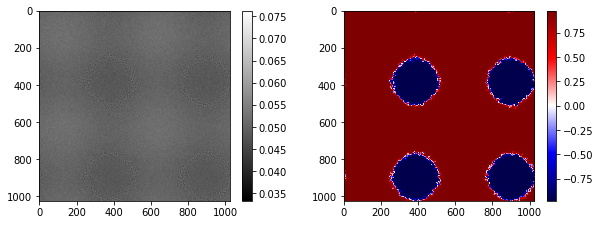

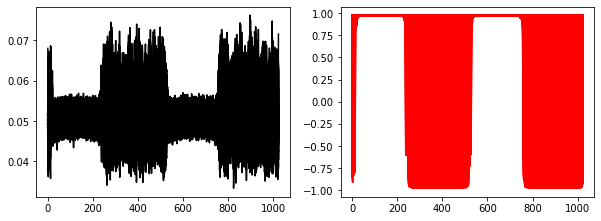

max_region_c: 0.07451671133890161 , max_region_s: 0.977393471506064
min_region_c: 0.034120370279127066 , min_region_s: -0.9778848373889699
amplitude_c: 0.020198170529887274 , amplitude_s: 0.9776391544475169
 
time_step= 1200
Tiempo CPU en segundos: 10987.66
c.mean = 0.0500 s.mean = 0.6128
c.min  = 0.0252  s.min = -0.9789
c.max  = 0.0892  s.max = 0.9781


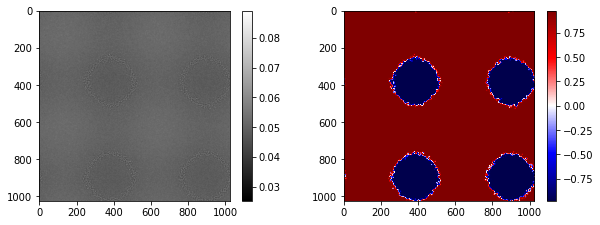

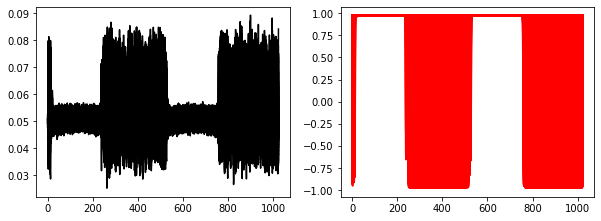

max_region_c: 0.08659433110265094 , max_region_s: 0.9781403312826129
min_region_c: 0.025213090396924313 , min_region_s: -0.9788838849805388
amplitude_c: 0.030690620352863313 , amplitude_s: 0.9785121081315759
 
time_step= 1300
Tiempo CPU en segundos: 11880.35
c.mean = 0.0500 s.mean = 0.6129
c.min  = 0.0178  s.min = -0.9789
c.max  = 0.1001  s.max = 0.9786


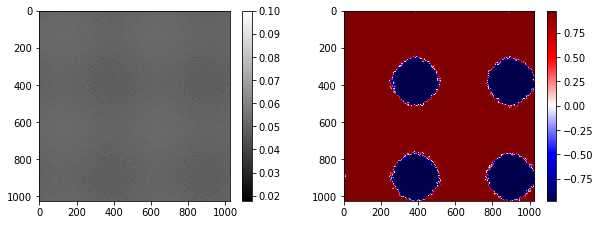

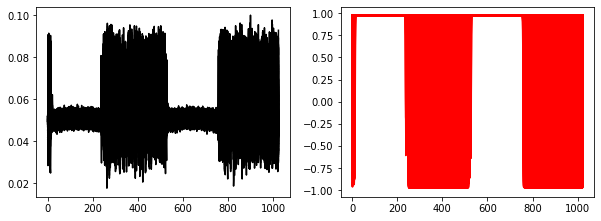

max_region_c: 0.09624168696702096 , max_region_s: 0.9785490667209307
min_region_c: 0.017786251962533747 , min_region_s: -0.978911755975494
amplitude_c: 0.0392277175022436 , amplitude_s: 0.9787304113482123
 
time_step= 1400
Tiempo CPU en segundos: 12782.14
c.mean = 0.0500 s.mean = 0.6129
c.min  = 0.0127  s.min = -0.9797
c.max  = 0.1070  s.max = 0.9794


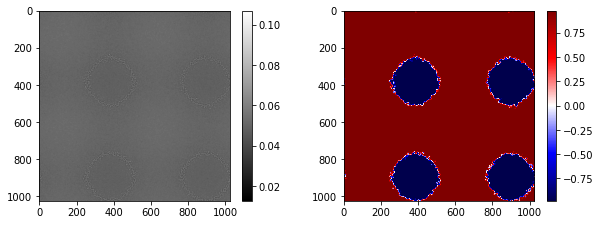

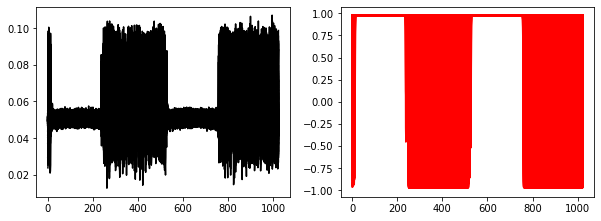

max_region_c: 0.10387038392759525 , max_region_s: 0.9794490399458893
min_region_c: 0.01267275081964558 , min_region_s: -0.9795026045105042
amplitude_c: 0.04559881655397483 , amplitude_s: 0.9794758222281967
 
time_step= 1500
Tiempo CPU en segundos: 13679.47
c.mean = 0.0500 s.mean = 0.6130
c.min  = 0.0098  s.min = -0.9801
c.max  = 0.1118  s.max = 0.9803


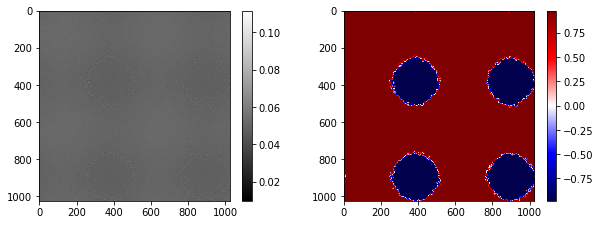

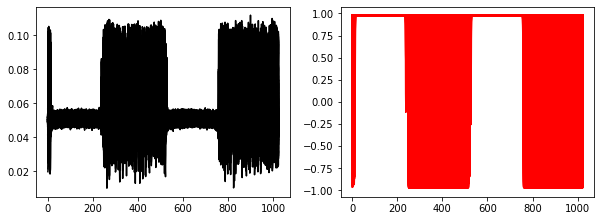

max_region_c: 0.10924958146094275 , max_region_s: 0.9796460244843687
min_region_c: 0.009809964776084574 , min_region_s: -0.9797549222272127
amplitude_c: 0.04971980834242909 , amplitude_s: 0.9797004733557907
 
time_step= 1600
Tiempo CPU en segundos: 14572.31
c.mean = 0.0500 s.mean = 0.6130
c.min  = 0.0076  s.min = -0.9808
c.max  = 0.1151  s.max = 0.9803


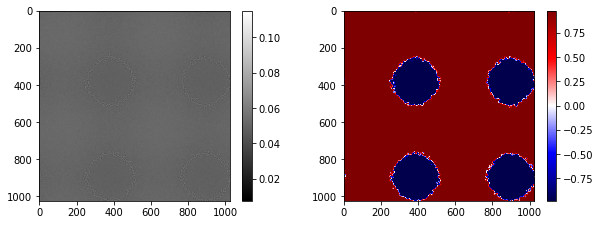

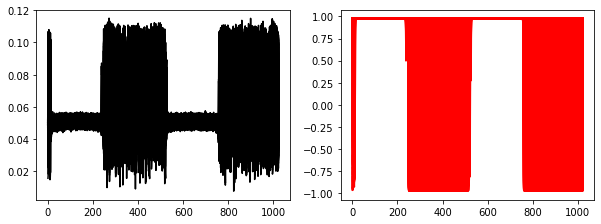

max_region_c: 0.1150885703612711 , max_region_s: 0.9797803385042048
min_region_c: 0.008986408512138435 , min_region_s: -0.9798867097441429
amplitude_c: 0.053051080924566334 , amplitude_s: 0.9798335241241738
 
time_step= 1700
Tiempo CPU en segundos: 15466.45
c.mean = 0.0500 s.mean = 0.6130
c.min  = 0.0059  s.min = -0.9815
c.max  = 0.1170  s.max = 0.9807


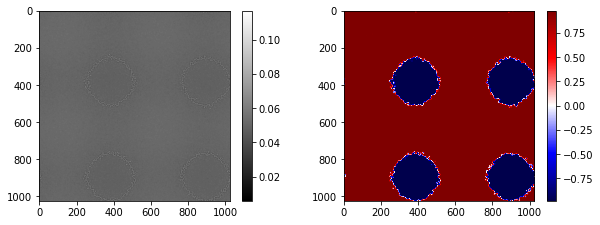

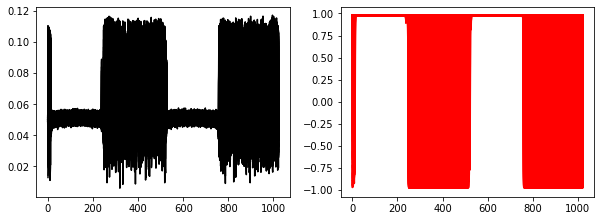

max_region_c: 0.11630312006519089 , max_region_s: 0.980749520618812
min_region_c: 0.005855984754586099 , min_region_s: -0.9808760141109735
amplitude_c: 0.0552235676553024 , amplitude_s: 0.9808127673648928
 
time_step= 1800
Tiempo CPU en segundos: 16376.62
c.mean = 0.0500 s.mean = 0.6131
c.min  = 0.0041  s.min = -0.9821
c.max  = 0.1192  s.max = 0.9813


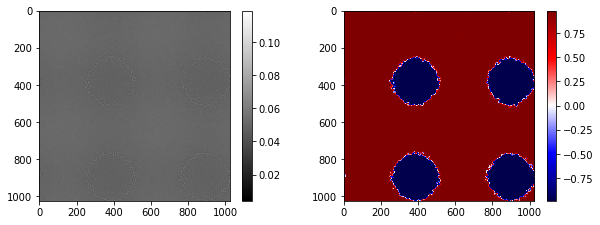

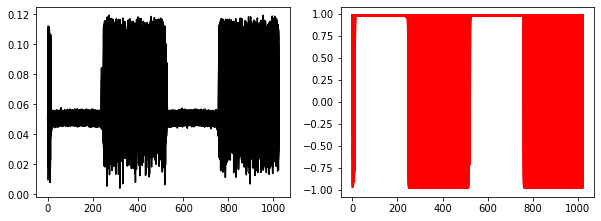

max_region_c: 0.11915463680115053 , max_region_s: 0.9812089206028466
min_region_c: 0.004116990368901011 , min_region_s: -0.9810248944057133
amplitude_c: 0.05751882321612476 , amplitude_s: 0.9811169075042799
 
time_step= 1900
Tiempo CPU en segundos: 17335.03
c.mean = 0.0500 s.mean = 0.6131
c.min  = 0.0036  s.min = -0.9825
c.max  = 0.1209  s.max = 0.9820


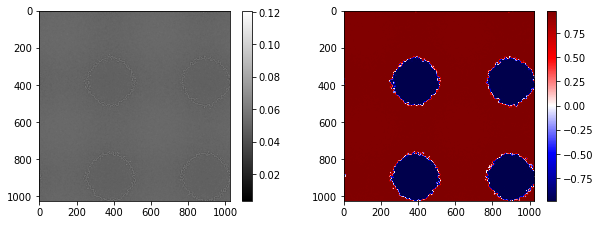

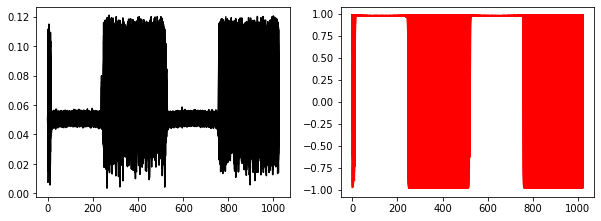

max_region_c: 0.12091838433246473 , max_region_s: 0.9819951775711647
min_region_c: 0.003608640735862404 , min_region_s: -0.98113285478872
amplitude_c: 0.05865487179830116 , amplitude_s: 0.9815640161799424
 
time_step= 2000
Tiempo CPU en segundos: 18241.10
c.mean = 0.0500 s.mean = 0.6131
c.min  = 0.0029  s.min = -0.9830
c.max  = 0.1228  s.max = 0.9827


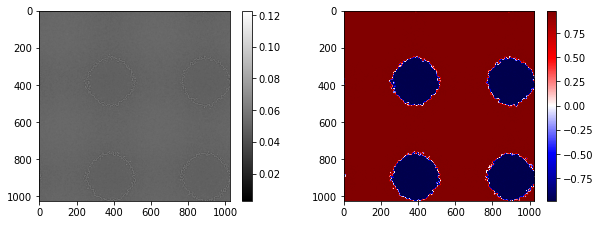

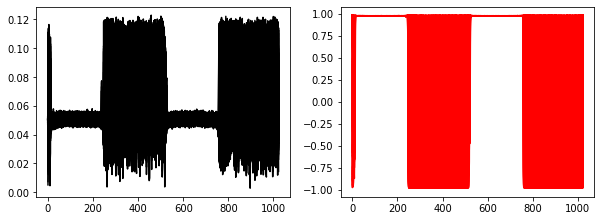

max_region_c: 0.12280906416165985 , max_region_s: 0.9826918281968444
min_region_c: 0.0037017664140984387 , min_region_s: -0.9813409008302976
amplitude_c: 0.0595536488737807 , amplitude_s: 0.982016364513571
 
time_step= 2100
Tiempo CPU en segundos: 19207.32
c.mean = 0.0500 s.mean = 0.6132
c.min  = 0.0028  s.min = -0.9837
c.max  = 0.1232  s.max = 0.9830


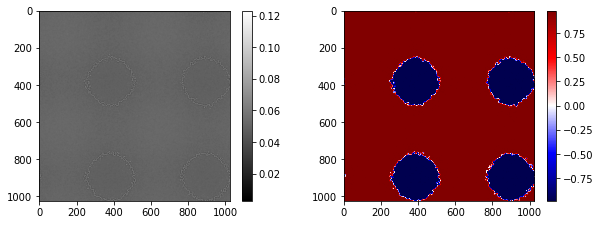

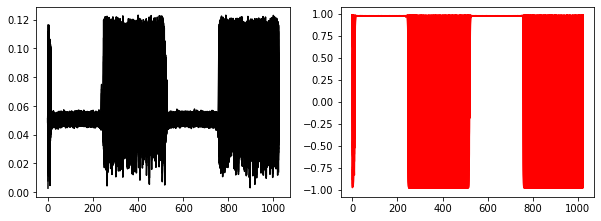

max_region_c: 0.12316823780857579 , max_region_s: 0.9829661510759945
min_region_c: 0.004444641590330815 , min_region_s: -0.9823534800535622
amplitude_c: 0.05936179810912249 , amplitude_s: 0.9826598155647783
 
time_step= 2200
Tiempo CPU en segundos: 20200.78
c.mean = 0.0500 s.mean = 0.6132
c.min  = 0.0028  s.min = -0.9838
c.max  = 0.1249  s.max = 0.9834


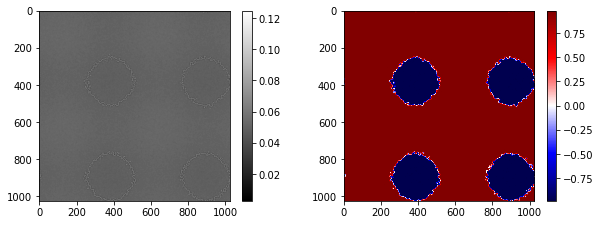

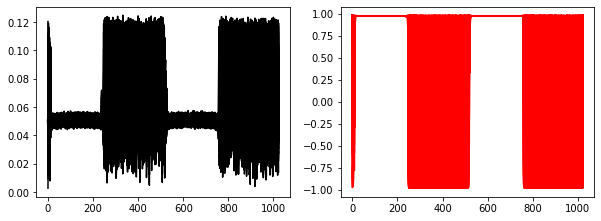

max_region_c: 0.12487592427755737 , max_region_s: 0.9833614997186046
min_region_c: 0.004771055004519293 , min_region_s: -0.9819968220386004
amplitude_c: 0.060052434636519034 , amplitude_s: 0.9826791608786025
 
time_step= 2300
Tiempo CPU en segundos: 21146.55
c.mean = 0.0500 s.mean = 0.6132
c.min  = 0.0015  s.min = -0.9843
c.max  = 0.1259  s.max = 0.9839


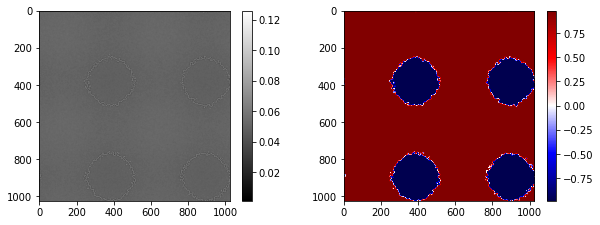

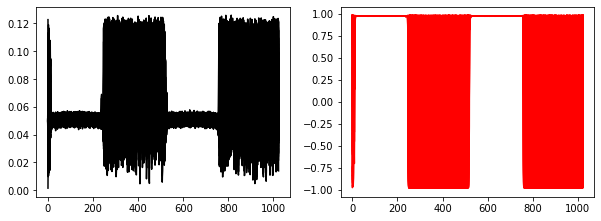

max_region_c: 0.12559906384879752 , max_region_s: 0.9838882033762782
min_region_c: 0.0046479672231801855 , min_region_s: -0.9824836327984969
amplitude_c: 0.060475548312808665 , amplitude_s: 0.9831859180873876
 
time_step= 2400
Tiempo CPU en segundos: 22061.85
c.mean = 0.0500 s.mean = 0.6133
c.min  = 0.0010  s.min = -0.9841
c.max  = 0.1282  s.max = 0.9838


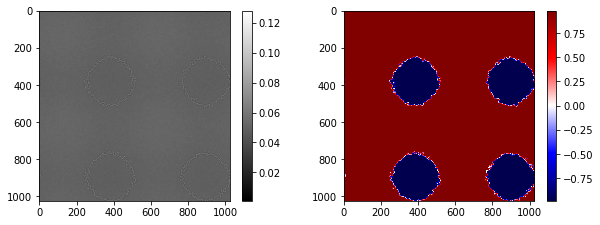

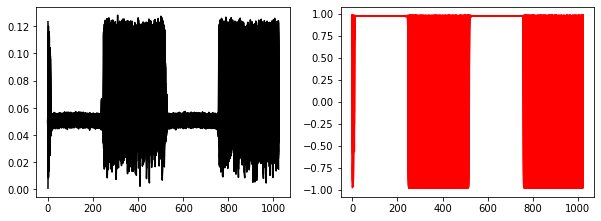

max_region_c: 0.12817375039183648 , max_region_s: 0.983848627280072
min_region_c: 0.0023713978205598357 , min_region_s: -0.9827577307518457
amplitude_c: 0.06290117628563832 , amplitude_s: 0.9833031790159589
 
time_step= 2500
Tiempo CPU en segundos: 22973.18
c.mean = 0.0500 s.mean = 0.6133
c.min  = 0.0022  s.min = -0.9852
c.max  = 0.1282  s.max = 0.9844


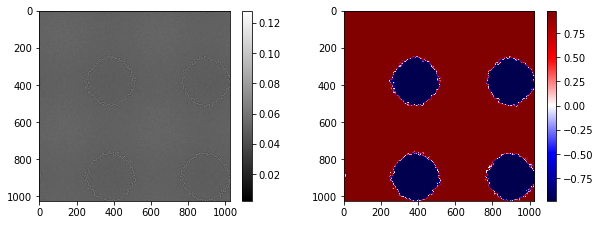

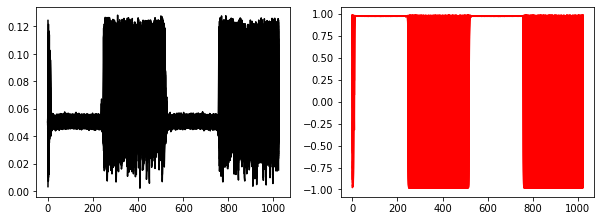

max_region_c: 0.1282002659335194 , max_region_s: 0.9838693112823023
min_region_c: 0.0022176595802679863 , min_region_s: -0.9831297051185257
amplitude_c: 0.06299130317662571 , amplitude_s: 0.983499508200414
 
time_step= 2600
Tiempo CPU en segundos: 23918.18
c.mean = 0.0500 s.mean = 0.6133
c.min  = 0.0012  s.min = -0.9849
c.max  = 0.1291  s.max = 0.9843


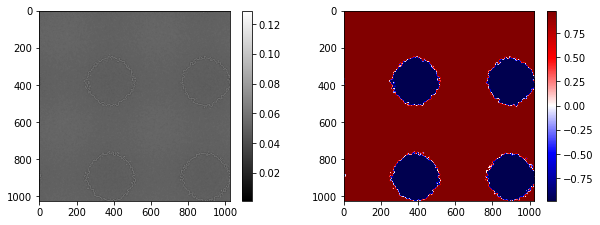

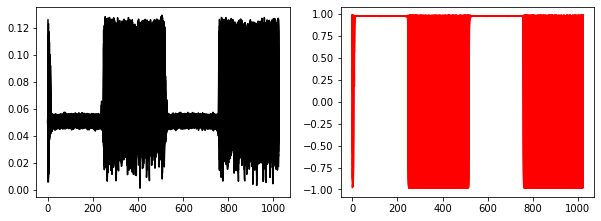

max_region_c: 0.1291247417238003 , max_region_s: 0.9842557498003043
min_region_c: 0.0012219925107941083 , min_region_s: -0.9833632588128239
amplitude_c: 0.0639513746065031 , amplitude_s: 0.9838095043065641
 
time_step= 2700
Tiempo CPU en segundos: 24841.51
c.mean = 0.0500 s.mean = 0.6133
c.min  = 0.0012  s.min = -0.9857
c.max  = 0.1293  s.max = 0.9854


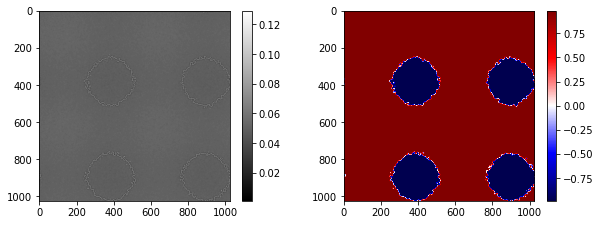

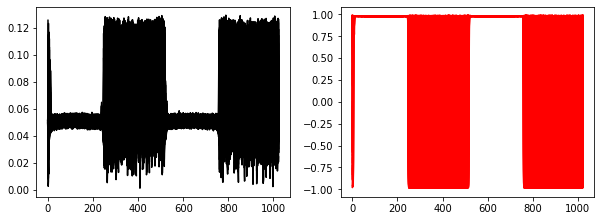

max_region_c: 0.12896941880281165 , max_region_s: 0.9849658418710932
min_region_c: 0.0011651132561299826 , min_region_s: -0.9837505467576699
amplitude_c: 0.06390215277334084 , amplitude_s: 0.9843581943143815
 
time_step= 2800
Tiempo CPU en segundos: 25775.77
c.mean = 0.0500 s.mean = 0.6133
c.min  = 0.0014  s.min = -0.9850
c.max  = 0.1298  s.max = 0.9848


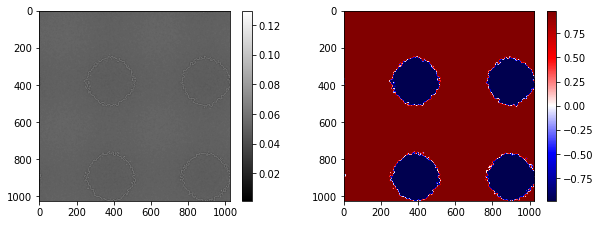

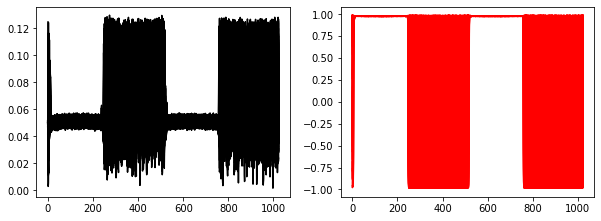

max_region_c: 0.12979930928588668 , max_region_s: 0.9847694544262513
min_region_c: 0.003468203464897721 , min_region_s: -0.983916623895854
amplitude_c: 0.06316555291049447 , amplitude_s: 0.9843430391610526
 
time_step= 2900
Tiempo CPU en segundos: 26716.42
c.mean = 0.0500 s.mean = 0.6134
c.min  = 0.0010  s.min = -0.9862
c.max  = 0.1293  s.max = 0.9855


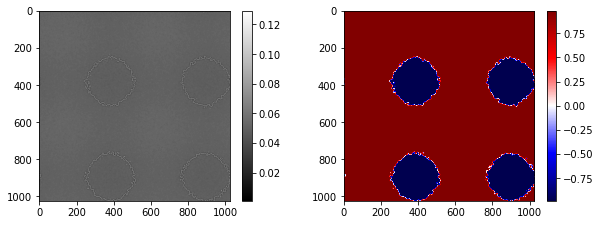

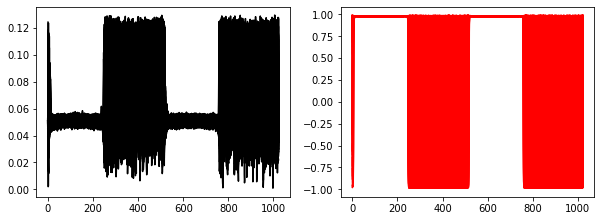

max_region_c: 0.12922142579873042 , max_region_s: 0.9849682866230561
min_region_c: 0.006431765489815939 , min_region_s: -0.9840962802989538
amplitude_c: 0.061394830154457236 , amplitude_s: 0.984532283461005
 
time_step= 3000
Tiempo CPU en segundos: 27674.83
c.mean = 0.0500 s.mean = 0.6134
c.min  = -0.0004  s.min = -0.9865
c.max  = 0.1306  s.max = 0.9862


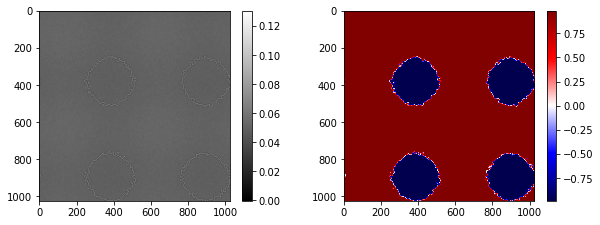

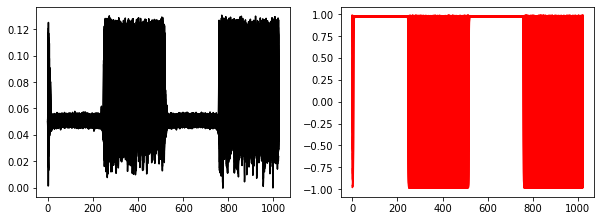

max_region_c: 0.13009814246894338 , max_region_s: 0.9854968771074202
min_region_c: 0.007662674194046668 , min_region_s: -0.9848655223179082
amplitude_c: 0.06121773413744836 , amplitude_s: 0.9851811997126643
 
time_step= 3100
Tiempo CPU en segundos: 28638.01
c.mean = 0.0500 s.mean = 0.6134
c.min  = -0.0016  s.min = -0.9862
c.max  = 0.1309  s.max = 0.9855


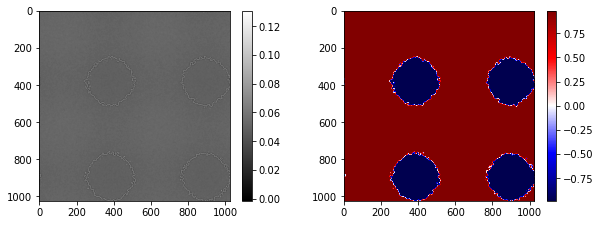

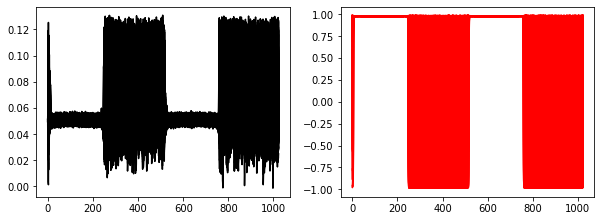

max_region_c: 0.13088748910255896 , max_region_s: 0.9854596246491771
min_region_c: 0.006448115281300186 , min_region_s: -0.9849388931177796
amplitude_c: 0.06221968691062939 , amplitude_s: 0.9851992588834784
 
time_step= 3200
Tiempo CPU en segundos: 29604.90
c.mean = 0.0500 s.mean = 0.6134
c.min  = -0.0044  s.min = -0.9866
c.max  = 0.1312  s.max = 0.9859


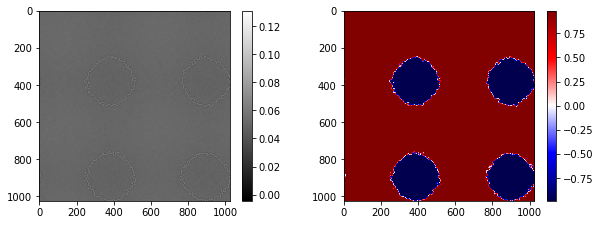

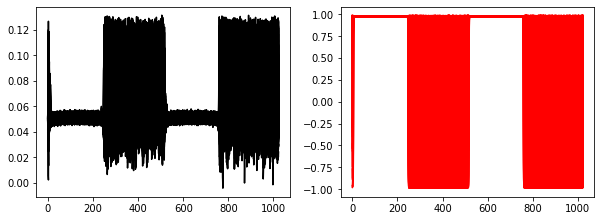

max_region_c: 0.13123867477685 , max_region_s: 0.9853107600482345
min_region_c: 0.006308181112768376 , min_region_s: -0.985013279273848
amplitude_c: 0.06246524683204081 , amplitude_s: 0.9851620196610412
 
time_step= 3300
Tiempo CPU en segundos: 30630.12
c.mean = 0.0500 s.mean = 0.6135
c.min  = -0.0044  s.min = -0.9866
c.max  = 0.1320  s.max = 0.9860


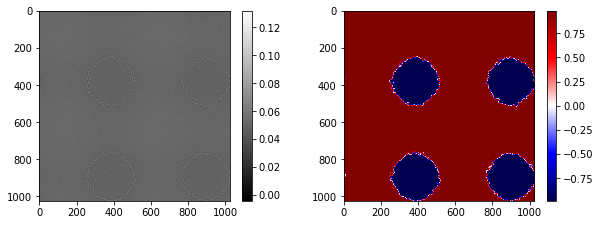

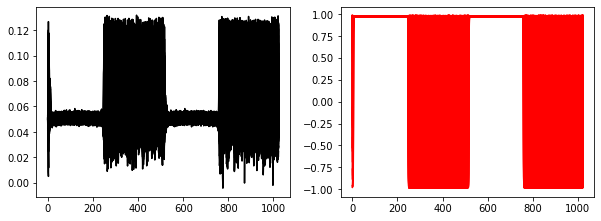

max_region_c: 0.13197412092618108 , max_region_s: 0.9857936971468575
min_region_c: 0.006760575401680757 , min_region_s: -0.9851209960444828
amplitude_c: 0.06260677276225016 , amplitude_s: 0.9854573465956702
 
time_step= 3400
Tiempo CPU en segundos: 31558.91
c.mean = 0.0500 s.mean = 0.6135
c.min  = -0.0044  s.min = -0.9864
c.max  = 0.1323  s.max = 0.9863


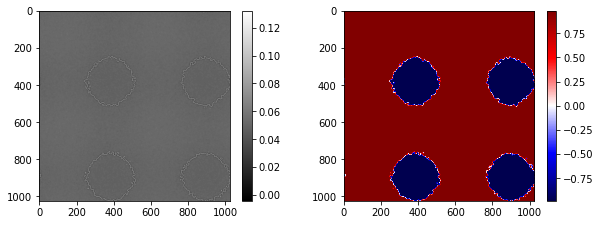

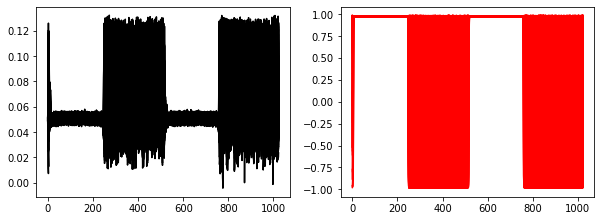

max_region_c: 0.132316285195193 , max_region_s: 0.9857143485895816
min_region_c: 0.0070428714789724 , min_region_s: -0.985036003104544
amplitude_c: 0.0626367068581103 , amplitude_s: 0.9853751758470628
 
time_step= 3500
Tiempo CPU en segundos: 32449.63
c.mean = 0.0500 s.mean = 0.6135
c.min  = -0.0063  s.min = -0.9863
c.max  = 0.1324  s.max = 0.9867


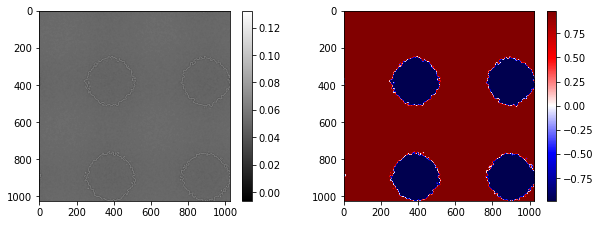

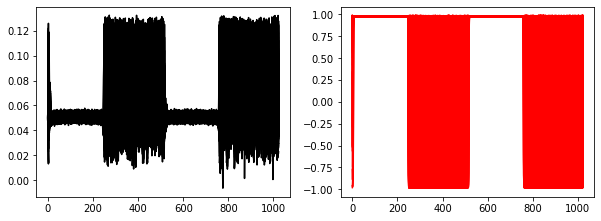

max_region_c: 0.13240431920477158 , max_region_s: 0.9866710441289476
min_region_c: 0.005590260360898919 , min_region_s: -0.9858373185258984
amplitude_c: 0.06340702942193634 , amplitude_s: 0.986254181327423
 
time_step= 3600
Tiempo CPU en segundos: 33384.99
c.mean = 0.0500 s.mean = 0.6135
c.min  = -0.0057  s.min = -0.9868
c.max  = 0.1340  s.max = 0.9866


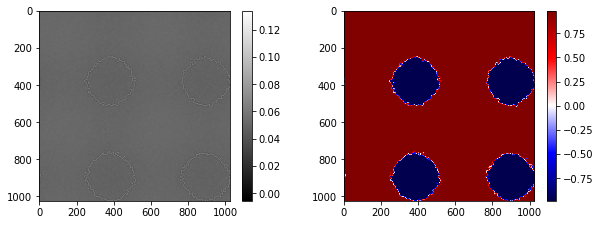

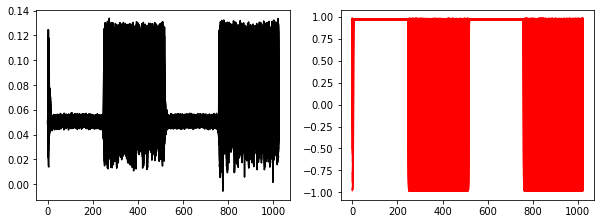

max_region_c: 0.133974221789618 , max_region_s: 0.9865016768889188
min_region_c: 0.005330147718168432 , min_region_s: -0.9863340096703367
amplitude_c: 0.06432203703572478 , amplitude_s: 0.9864178432796278
 
time_step= 3700
Tiempo CPU en segundos: 34313.52
c.mean = 0.0500 s.mean = 0.6136
c.min  = -0.0063  s.min = -0.9862
c.max  = 0.1342  s.max = 0.9860


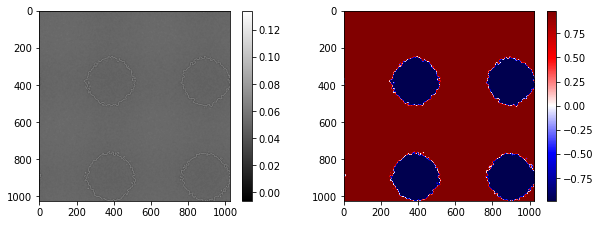

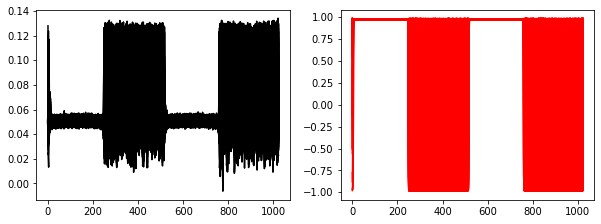

max_region_c: 0.13251116469474675 , max_region_s: 0.9857606202361009
min_region_c: 0.0056114526228487 , min_region_s: -0.9862087378592912
amplitude_c: 0.06344985603594902 , amplitude_s: 0.985984679047696
 
time_step= 3800
Tiempo CPU en segundos: 35241.68
c.mean = 0.0500 s.mean = 0.6136
c.min  = -0.0076  s.min = -0.9873
c.max  = 0.1336  s.max = 0.9863


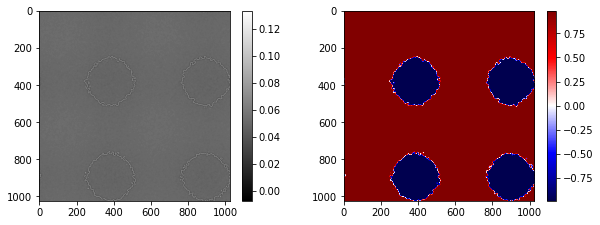

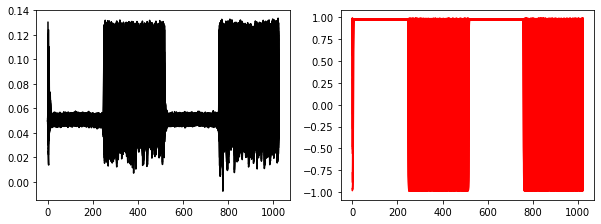

max_region_c: 0.132102256408118 , max_region_s: 0.9862935135176906
min_region_c: 0.004532413384279019 , min_region_s: -0.9864462091093291
amplitude_c: 0.0637849215119195 , amplitude_s: 0.9863698613135099
 
time_step= 3900
Tiempo CPU en segundos: 36157.87
c.mean = 0.0500 s.mean = 0.6136
c.min  = -0.0063  s.min = -0.9867
c.max  = 0.1334  s.max = 0.9863


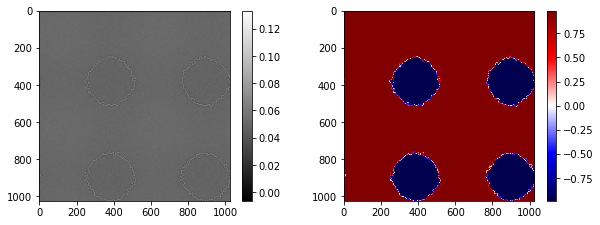

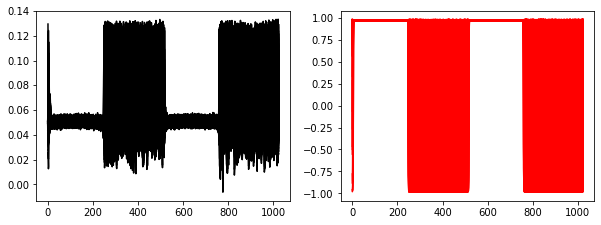

max_region_c: 0.13315070989546268 , max_region_s: 0.9863459416873985
min_region_c: 0.004078624317182 , min_region_s: -0.9865285057374679
amplitude_c: 0.06453604278914034 , amplitude_s: 0.9864372237124333
 
time_step= 4000
Tiempo CPU en segundos: 37060.37
c.mean = 0.0500 s.mean = 0.6136
c.min  = -0.0065  s.min = -0.9880
c.max  = 0.1340  s.max = 0.9871


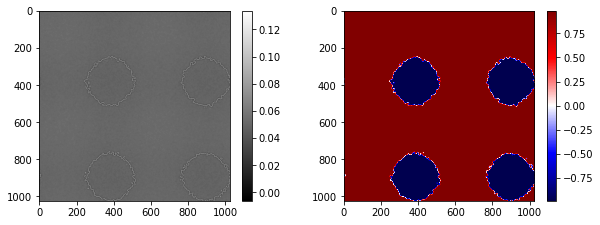

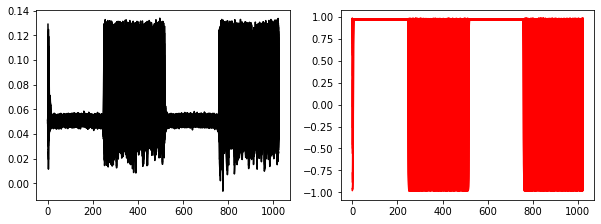

max_region_c: 0.1339672376347643 , max_region_s: 0.9870633422133702
min_region_c: 0.0020064571862728913 , min_region_s: -0.9864691703868811
amplitude_c: 0.0659803902242457 , amplitude_s: 0.9867662563001256
 
time_step= 4100
Tiempo CPU en segundos: 37977.77
c.mean = 0.0500 s.mean = 0.6136
c.min  = -0.0053  s.min = -0.9874
c.max  = 0.1355  s.max = 0.9865


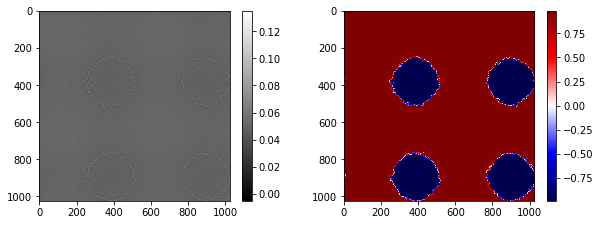

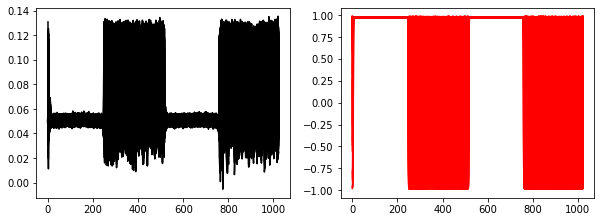

max_region_c: 0.1343726303020901 , max_region_s: 0.9864954711132915
min_region_c: 0.0009030184435021529 , min_region_s: -0.9870767821328387
amplitude_c: 0.06673480592929397 , amplitude_s: 0.9867861266230651
 
time_step= 4200
Tiempo CPU en segundos: 38870.97
c.mean = 0.0500 s.mean = 0.6136
c.min  = -0.0016  s.min = -0.9873
c.max  = 0.1354  s.max = 0.9868


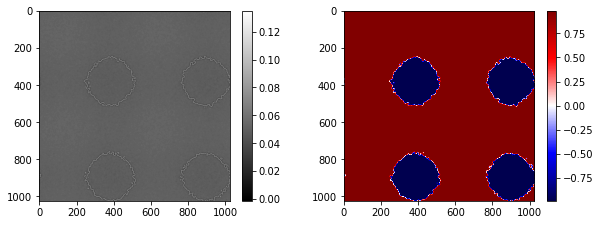

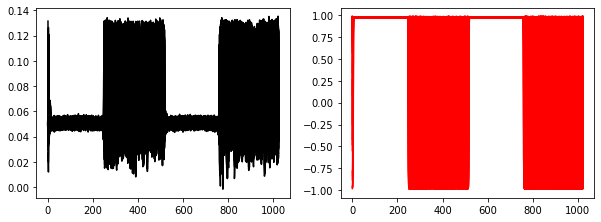

max_region_c: 0.13420978711188328 , max_region_s: 0.9865732309137019
min_region_c: 0.0008639051369800954 , min_region_s: -0.9868586003006568
amplitude_c: 0.06667294098745159 , amplitude_s: 0.9867159156071793
 
time_step= 4300
Tiempo CPU en segundos: 39789.35
c.mean = 0.0500 s.mean = 0.6137
c.min  = 0.0011  s.min = -0.9870
c.max  = 0.1351  s.max = 0.9868


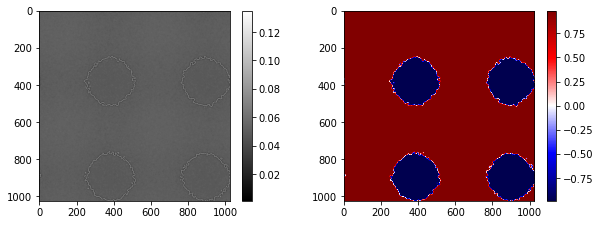

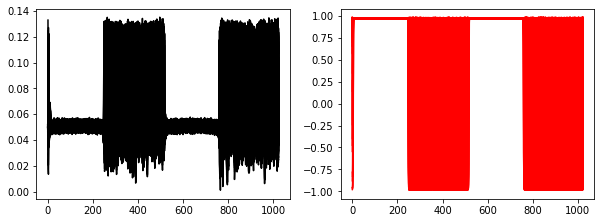

max_region_c: 0.13512801067634578 , max_region_s: 0.9860436995648183
min_region_c: 0.0011132030379917084 , min_region_s: -0.986777071751405
amplitude_c: 0.06700740381917704 , amplitude_s: 0.9864103856581117
 
time_step= 4400
Tiempo CPU en segundos: 40738.40
c.mean = 0.0500 s.mean = 0.6137
c.min  = -0.0004  s.min = -0.9873
c.max  = 0.1359  s.max = 0.9868


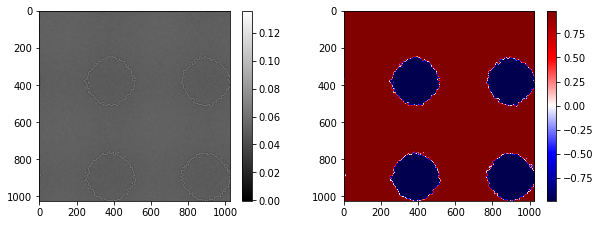

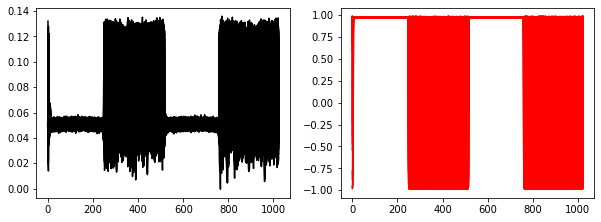

max_region_c: 0.13513719351992223 , max_region_s: 0.9868460394405562
min_region_c: -0.0003859653679345452 , min_region_s: -0.9867157553519664
amplitude_c: 0.06776157944392838 , amplitude_s: 0.9867808973962613
 
time_step= 4500
Tiempo CPU en segundos: 41667.55
c.mean = 0.0500 s.mean = 0.6137
c.min  = -0.0005  s.min = -0.9873
c.max  = 0.1358  s.max = 0.9869


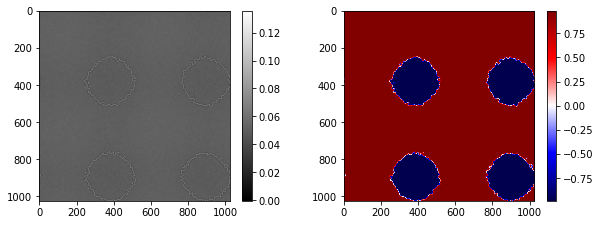

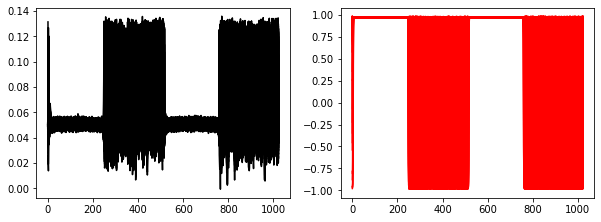

max_region_c: 0.13560591571331979 , max_region_s: 0.986701247258829
min_region_c: -0.0005270306539904643 , min_region_s: -0.9872403917264473
amplitude_c: 0.06806647318365512 , amplitude_s: 0.9869708194926381
 
time_step= 4600
Tiempo CPU en segundos: 42582.84
c.mean = 0.0500 s.mean = 0.6137
c.min  = -0.0011  s.min = -0.9876
c.max  = 0.1360  s.max = 0.9868


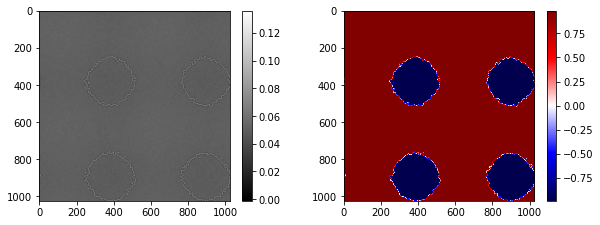

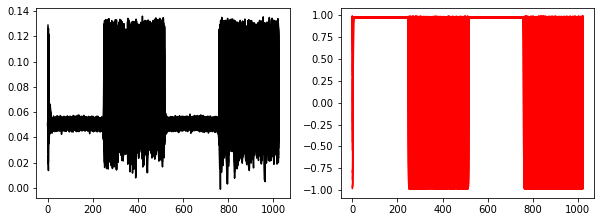

max_region_c: 0.13601324446689872 , max_region_s: 0.9857314393364882
min_region_c: -0.00112337781910943 , min_region_s: -0.9875770012536537
amplitude_c: 0.06856831114300407 , amplitude_s: 0.986654220295071
 
time_step= 4700
Tiempo CPU en segundos: 43522.16
c.mean = 0.0500 s.mean = 0.6137
c.min  = -0.0018  s.min = -0.9871
c.max  = 0.1360  s.max = 0.9871


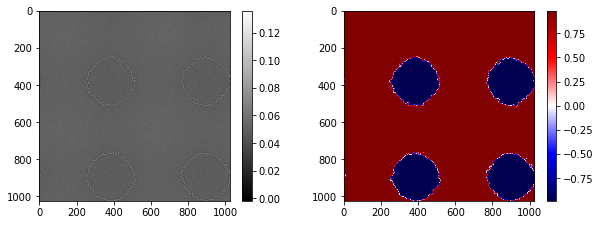

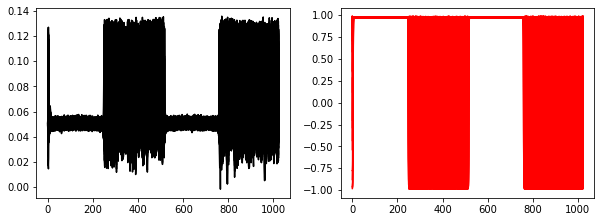

max_region_c: 0.1354852375005532 , max_region_s: 0.9870864096146061
min_region_c: -0.0018067815894057843 , min_region_s: -0.9871138462874324
amplitude_c: 0.06864600954497949 , amplitude_s: 0.9871001279510192
 
time_step= 4800
Tiempo CPU en segundos: 44444.08
c.mean = 0.0500 s.mean = 0.6137
c.min  = 0.0000  s.min = -0.9872
c.max  = 0.1364  s.max = 0.9871


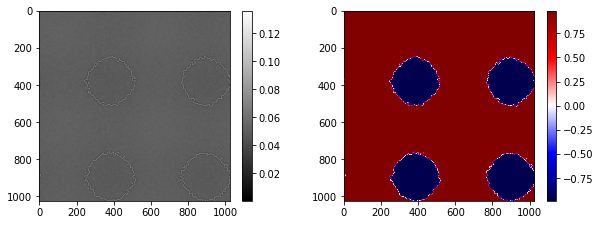

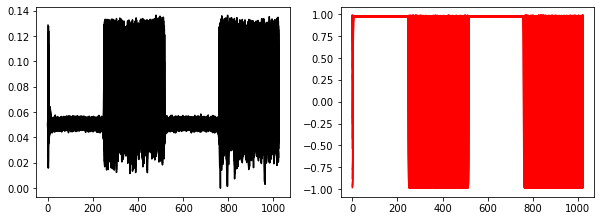

max_region_c: 0.1364181395860424 , max_region_s: 0.9861211559610308
min_region_c: 2.3375385893854576e-05 , min_region_s: -0.9872199907521125
amplitude_c: 0.06819738210007427 , amplitude_s: 0.9866705733565717
 
time_step= 4900
Tiempo CPU en segundos: 45338.84
c.mean = 0.0500 s.mean = 0.6137
c.min  = 0.0007  s.min = -0.9879
c.max  = 0.1367  s.max = 0.9879


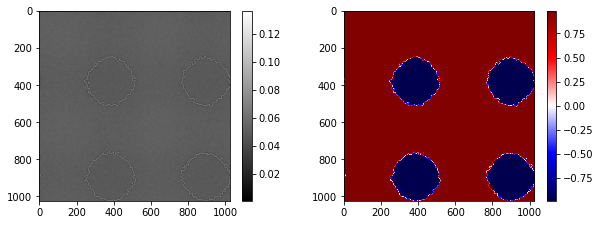

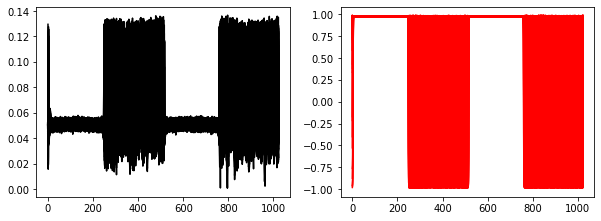

max_region_c: 0.13610815252036654 , max_region_s: 0.9858972240081393
min_region_c: 0.0008793277664002812 , min_region_s: -0.987896365842503
amplitude_c: 0.06761441237698312 , amplitude_s: 0.9868967949253211
 
time_step= 5000
Tiempo CPU en segundos: 46259.46
c.mean = 0.0500 s.mean = 0.6138
c.min  = -0.0007  s.min = -0.9884
c.max  = 0.1365  s.max = 0.9872


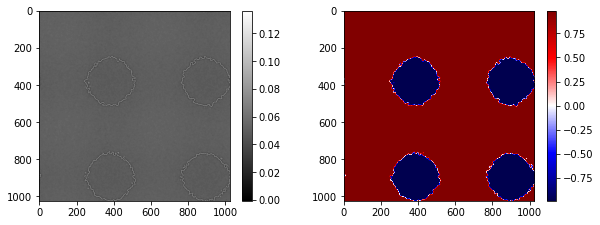

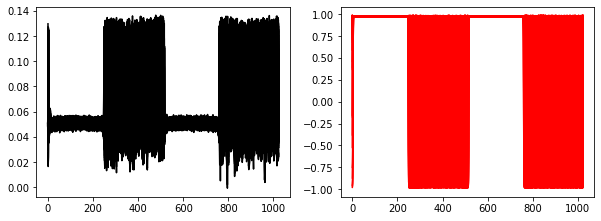

max_region_c: 0.1365337960455475 , max_region_s: 0.9858891219546909
min_region_c: 0.005121212819801947 , min_region_s: -0.988449464606435
amplitude_c: 0.06570629161287278 , amplitude_s: 0.9871692932805629
 
time_step= 5100
Tiempo CPU en segundos: 47183.08
c.mean = 0.0500 s.mean = 0.6138
c.min  = 0.0001  s.min = -0.9884
c.max  = 0.1373  s.max = 0.9868


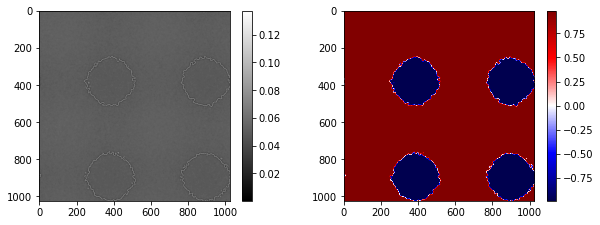

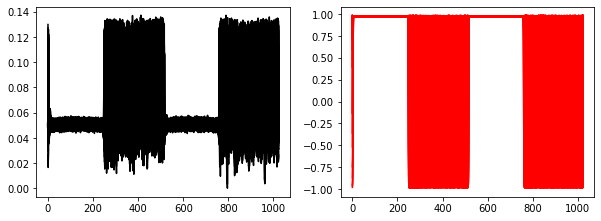

max_region_c: 0.1373099384136407 , max_region_s: 0.9860413113729851
min_region_c: 0.009649003181537932 , min_region_s: -0.9883785423889201
amplitude_c: 0.06383046761605138 , amplitude_s: 0.9872099268809527
 
time_step= 5200
Tiempo CPU en segundos: 48095.19
c.mean = 0.0500 s.mean = 0.6138
c.min  = 0.0011  s.min = -0.9886
c.max  = 0.1373  s.max = 0.9867


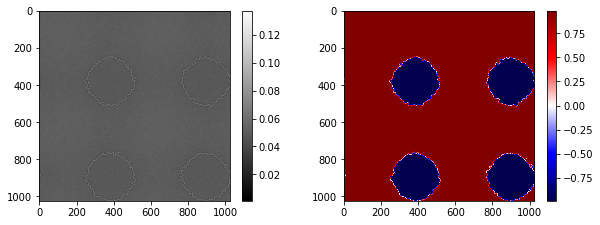

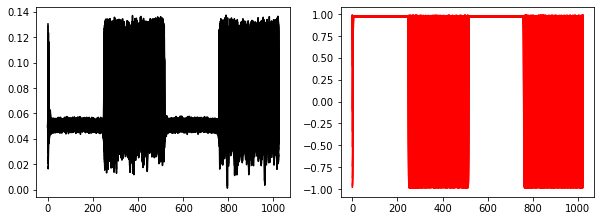

max_region_c: 0.13698605464235575 , max_region_s: 0.9860831471579746
min_region_c: 0.011694811790644454 , min_region_s: -0.9886154813441396
amplitude_c: 0.06264562142585564 , amplitude_s: 0.9873493142510571
 
time_step= 5300
Tiempo CPU en segundos: 49024.21
c.mean = 0.0500 s.mean = 0.6138
c.min  = 0.0007  s.min = -0.9890
c.max  = 0.1370  s.max = 0.9874


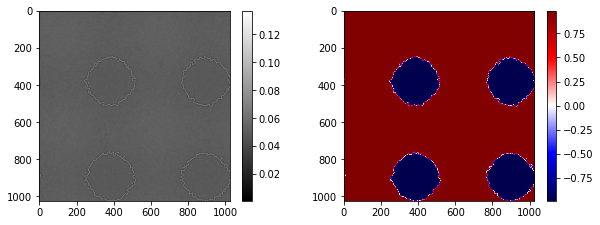

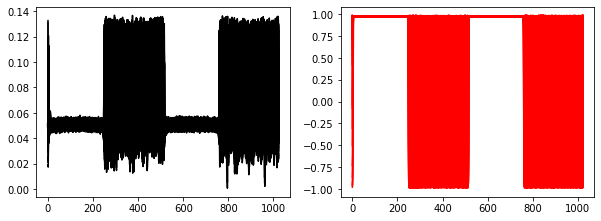

max_region_c: 0.13695356251316732 , max_region_s: 0.9860523384701446
min_region_c: 0.012497726377564553 , min_region_s: -0.9890484309645218
amplitude_c: 0.06222791806780138 , amplitude_s: 0.9875503847173333
 
time_step= 5400
Tiempo CPU en segundos: 49939.72
c.mean = 0.0500 s.mean = 0.6138
c.min  = 0.0011  s.min = -0.9882
c.max  = 0.1375  s.max = 0.9873


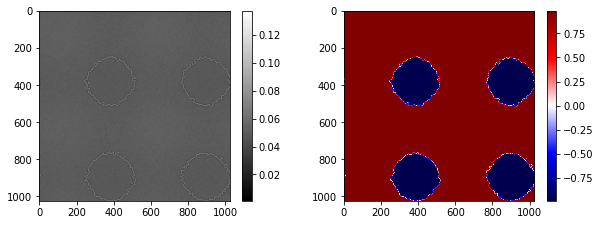

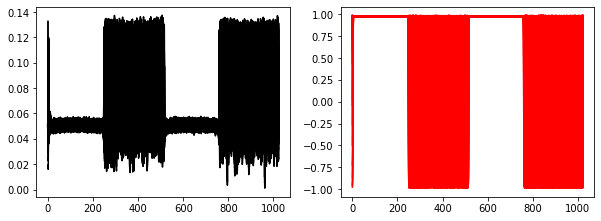

max_region_c: 0.13747703179631893 , max_region_s: 0.9859246171065053
min_region_c: 0.013422394700053866 , min_region_s: -0.988178993243807
amplitude_c: 0.06202731854813253 , amplitude_s: 0.9870518051751561
 
time_step= 5500
Tiempo CPU en segundos: 50876.20
c.mean = 0.0500 s.mean = 0.6139
c.min  = 0.0019  s.min = -0.9890
c.max  = 0.1370  s.max = 0.9870


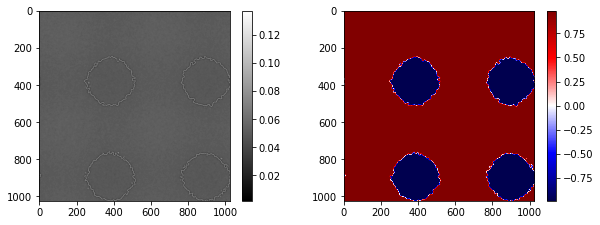

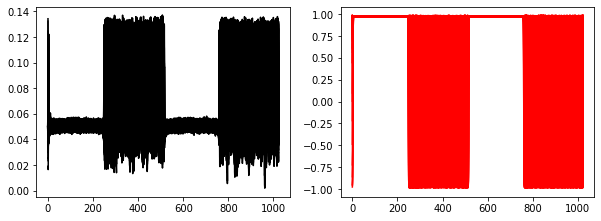

max_region_c: 0.1370105033354412 , max_region_s: 0.9859795889922529
min_region_c: 0.013296379469815494 , min_region_s: -0.9889977330497204
amplitude_c: 0.06185706193281286 , amplitude_s: 0.9874886610209866
 
time_step= 5600
Tiempo CPU en segundos: 51797.72
c.mean = 0.0500 s.mean = 0.6139
c.min  = 0.0016  s.min = -0.9890
c.max  = 0.1371  s.max = 0.9882


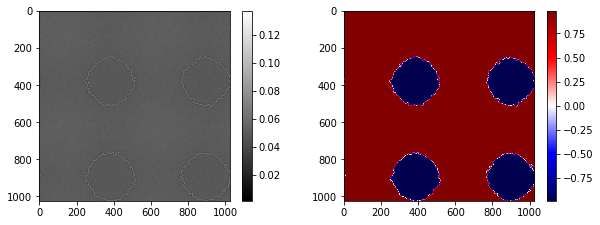

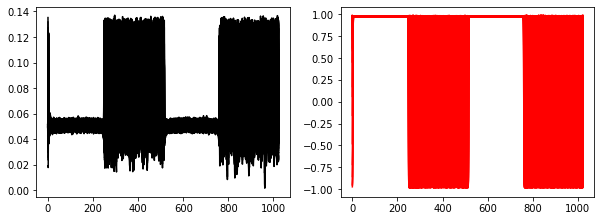

max_region_c: 0.13708303174400163 , max_region_s: 0.9852137487766102
min_region_c: 0.014243566229352002 , min_region_s: -0.9890104378324777
amplitude_c: 0.06141973275732482 , amplitude_s: 0.9871120933045439
 
time_step= 5700
Tiempo CPU en segundos: 52706.75
c.mean = 0.0500 s.mean = 0.6139
c.min  = -0.0001  s.min = -0.9893
c.max  = 0.1369  s.max = 0.9876


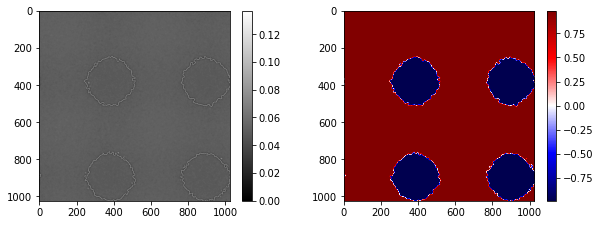

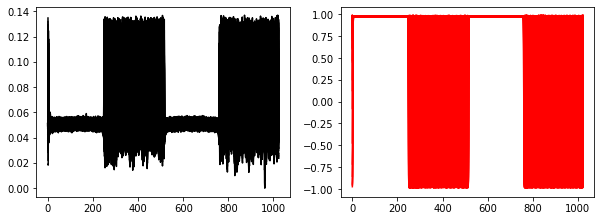

max_region_c: 0.13671142233635478 , max_region_s: 0.9856145558542502
min_region_c: 0.014136487125998716 , min_region_s: -0.9893251036177861
amplitude_c: 0.06128746760517803 , amplitude_s: 0.9874698297360182
 
time_step= 5800
Tiempo CPU en segundos: 53608.28
c.mean = 0.0500 s.mean = 0.6139
c.min  = -0.0010  s.min = -0.9892
c.max  = 0.1383  s.max = 0.9871


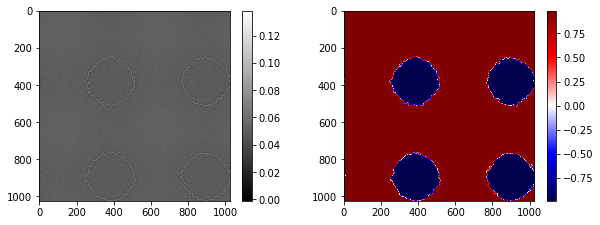

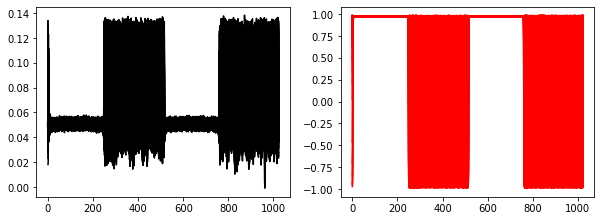

max_region_c: 0.1373095671469941 , max_region_s: 0.9860953008275736
min_region_c: 0.014250631806153064 , min_region_s: -0.9892354906963026
amplitude_c: 0.06152946767042052 , amplitude_s: 0.9876653957619381
 
time_step= 5900
Tiempo CPU en segundos: 54502.78
c.mean = 0.0500 s.mean = 0.6139
c.min  = -0.0010  s.min = -0.9884
c.max  = 0.1384  s.max = 0.9877


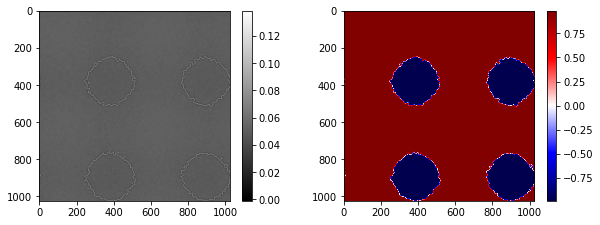

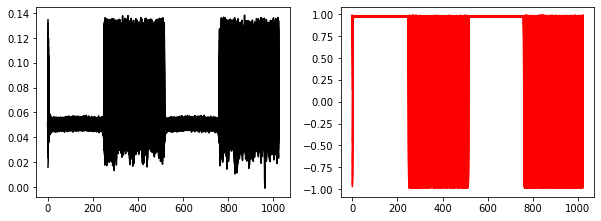

max_region_c: 0.13805388688839926 , max_region_s: 0.9858241175076479
min_region_c: 0.013164564265460659 , min_region_s: -0.988383861704132
amplitude_c: 0.0624446613114693 , amplitude_s: 0.98710398960589
 
time_step= 6000
Tiempo CPU en segundos: 55402.30
c.mean = 0.0500 s.mean = 0.6139
c.min  = -0.0021  s.min = -0.9883
c.max  = 0.1382  s.max = 0.9873


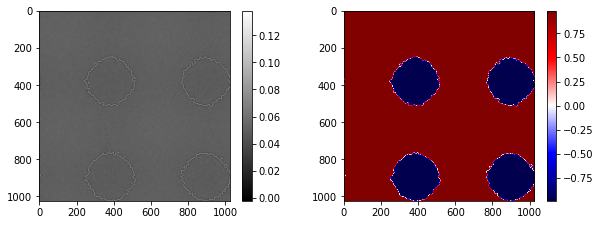

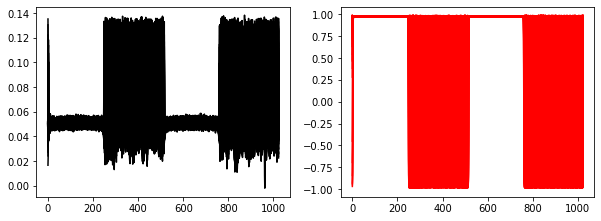

max_region_c: 0.1374135832770256 , max_region_s: 0.9866838910392977
min_region_c: 0.01292944094859506 , min_region_s: -0.9882512541369038
amplitude_c: 0.06224207116421527 , amplitude_s: 0.9874675725881008
 
time_step= 6100
Tiempo CPU en segundos: 56329.99
c.mean = 0.0500 s.mean = 0.6140
c.min  = -0.0016  s.min = -0.9881
c.max  = 0.1385  s.max = 0.9875


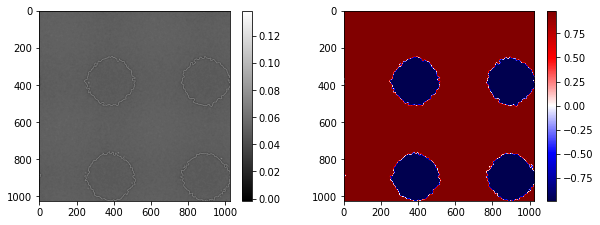

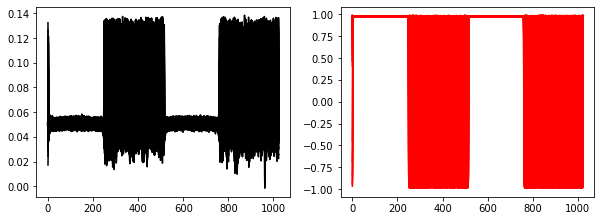

max_region_c: 0.1375240233450136 , max_region_s: 0.9874709518258002
min_region_c: 0.013529388085785115 , min_region_s: -0.9880543646030588
amplitude_c: 0.06199731762961424 , amplitude_s: 0.9877626582144295
 
time_step= 6200
Tiempo CPU en segundos: 57238.87
c.mean = 0.0500 s.mean = 0.6140
c.min  = -0.0026  s.min = -0.9886
c.max  = 0.1376  s.max = 0.9880


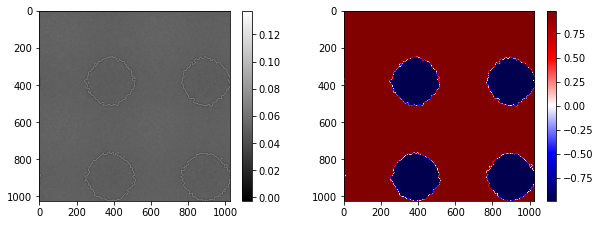

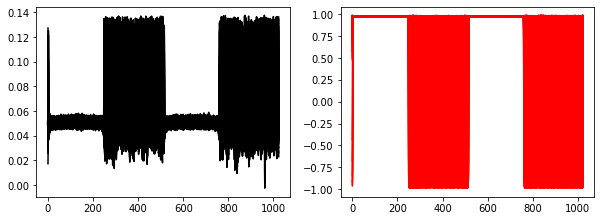

max_region_c: 0.13687490770042968 , max_region_s: 0.9872418955347557
min_region_c: 0.013319810472034356 , min_region_s: -0.9885551235565888
amplitude_c: 0.06177754861419766 , amplitude_s: 0.9878985095456723
 
time_step= 6300
Tiempo CPU en segundos: 58176.30
c.mean = 0.0500 s.mean = 0.6140
c.min  = -0.0012  s.min = -0.9881
c.max  = 0.1381  s.max = 0.9883


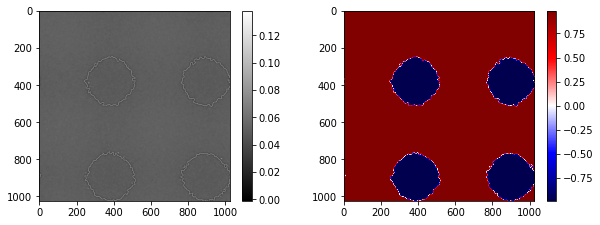

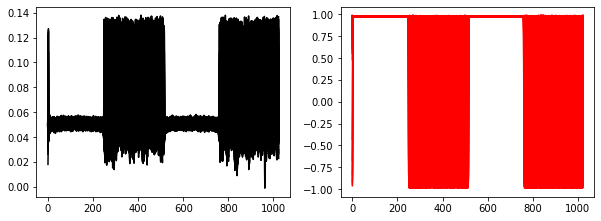

max_region_c: 0.1380978295842447 , max_region_s: 0.9864379444129986
min_region_c: 0.013758433707833384 , min_region_s: -0.9880531999479545
amplitude_c: 0.06216969793820566 , amplitude_s: 0.9872455721804765
 
time_step= 6400
Tiempo CPU en segundos: 59094.13
c.mean = 0.0500 s.mean = 0.6140
c.min  = -0.0004  s.min = -0.9882
c.max  = 0.1387  s.max = 0.9878


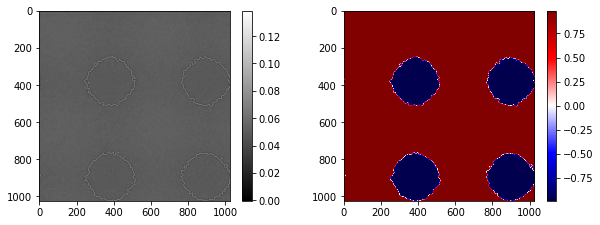

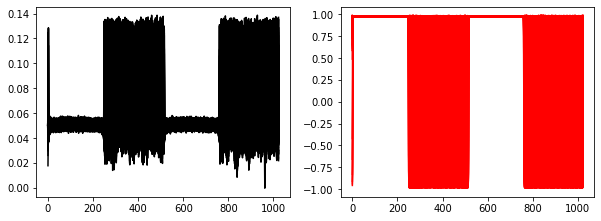

max_region_c: 0.13864261877479025 , max_region_s: 0.9857837206322199
min_region_c: 0.013878902569559863 , min_region_s: -0.9881738774067047
amplitude_c: 0.06238185810261519 , amplitude_s: 0.9869787990194623
 
time_step= 6500
Tiempo CPU en segundos: 60014.86
c.mean = 0.0500 s.mean = 0.6140
c.min  = 0.0033  s.min = -0.9888
c.max  = 0.1392  s.max = 0.9883


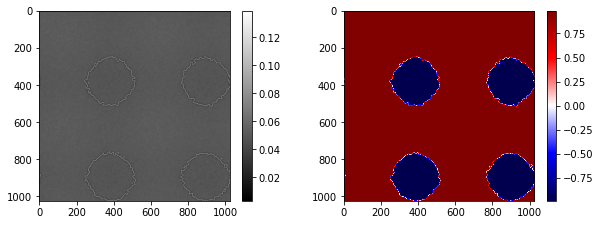

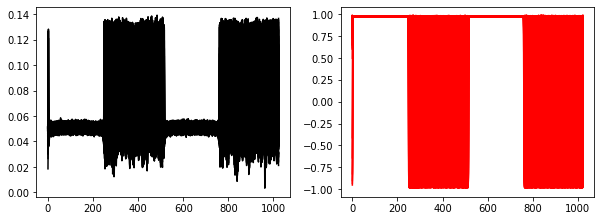

max_region_c: 0.13922336193668608 , max_region_s: 0.9865403026538776
min_region_c: 0.01225108719854473 , min_region_s: -0.988771660852414
amplitude_c: 0.06348613736907067 , amplitude_s: 0.9876559817531458
 
time_step= 6600
Tiempo CPU en segundos: 60953.73
c.mean = 0.0500 s.mean = 0.6140
c.min  = 0.0080  s.min = -0.9892
c.max  = 0.1384  s.max = 0.9885


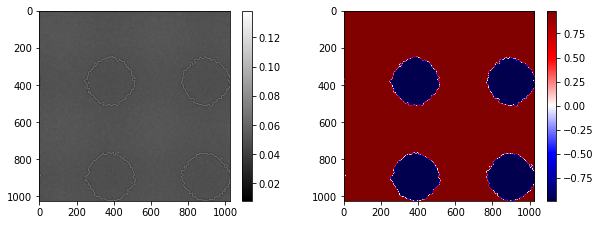

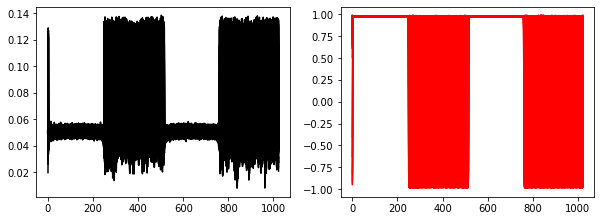

max_region_c: 0.13839000794066345 , max_region_s: 0.9860974598928013
min_region_c: 0.013784547182971058 , min_region_s: -0.9891645359632313
amplitude_c: 0.06230273037884619 , amplitude_s: 0.9876309979280162
 
time_step= 6700
Tiempo CPU en segundos: 61874.54
c.mean = 0.0500 s.mean = 0.6140
c.min  = 0.0088  s.min = -0.9886
c.max  = 0.1389  s.max = 0.9875


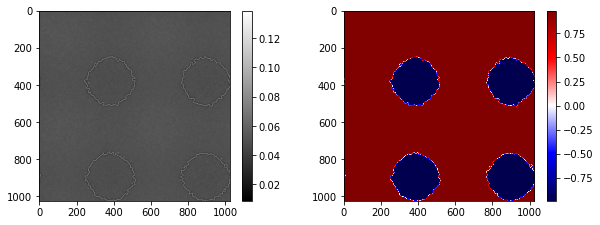

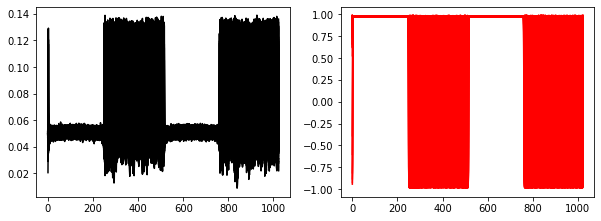

max_region_c: 0.13807136102249562 , max_region_s: 0.9865033623471551
min_region_c: 0.012680061036183401 , min_region_s: -0.9886089703347458
amplitude_c: 0.0626956499931561 , amplitude_s: 0.9875561663409504
 
time_step= 6800
Tiempo CPU en segundos: 62784.22
c.mean = 0.0500 s.mean = 0.6141
c.min  = 0.0082  s.min = -0.9896
c.max  = 0.1392  s.max = 0.9879


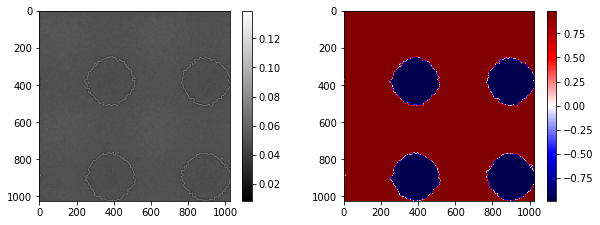

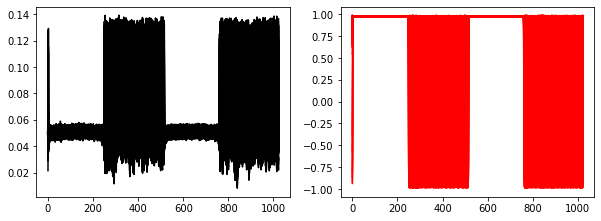

max_region_c: 0.1391905567816254 , max_region_s: 0.9867062773732578
min_region_c: 0.011531820210959824 , min_region_s: -0.9896394484603777
amplitude_c: 0.06382936828533278 , amplitude_s: 0.9881728629168177
 
time_step= 6900
Tiempo CPU en segundos: 63690.89
c.mean = 0.0500 s.mean = 0.6141
c.min  = 0.0076  s.min = -0.9904
c.max  = 0.1394  s.max = 0.9882


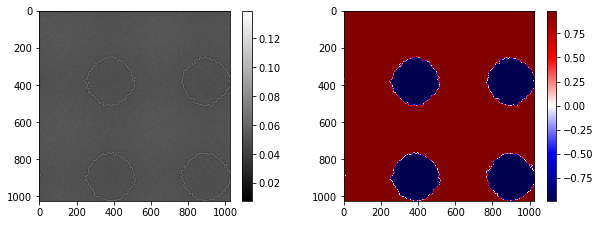

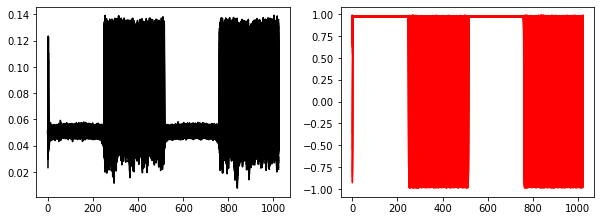

max_region_c: 0.1389498801632319 , max_region_s: 0.9865412893056464
min_region_c: 0.011353142032610548 , min_region_s: -0.9904070509084694
amplitude_c: 0.06379836906531068 , amplitude_s: 0.9884741701070578
 
time_step= 7000
Tiempo CPU en segundos: 64606.49
c.mean = 0.0500 s.mean = 0.6141
c.min  = 0.0065  s.min = -0.9904
c.max  = 0.1401  s.max = 0.9881


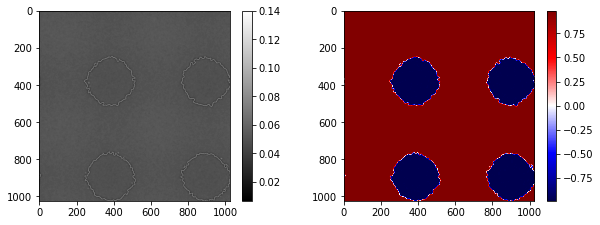

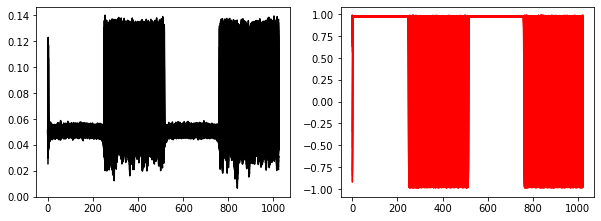

max_region_c: 0.139042605063984 , max_region_s: 0.9869000150760981
min_region_c: 0.012269545287557394 , min_region_s: -0.9903569656133051
amplitude_c: 0.0633865298882133 , amplitude_s: 0.9886284903447016
 
time_step= 7100
Tiempo CPU en segundos: 65518.95
c.mean = 0.0500 s.mean = 0.6141
c.min  = 0.0060  s.min = -0.9897
c.max  = 0.1400  s.max = 0.9882


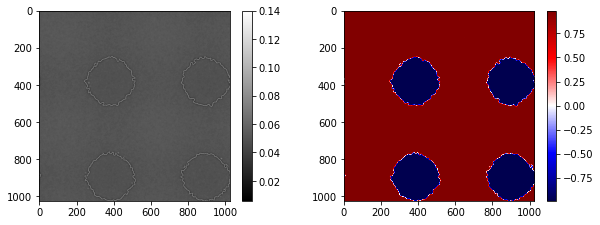

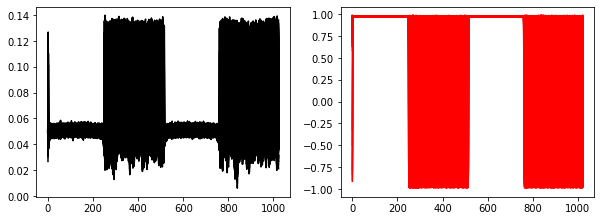

max_region_c: 0.13907393047342248 , max_region_s: 0.9879890645668208
min_region_c: 0.012659616118298179 , min_region_s: -0.9897447756567928
amplitude_c: 0.06320715717756215 , amplitude_s: 0.9888669201118068
 
time_step= 7200
Tiempo CPU en segundos: 66425.12
c.mean = 0.0500 s.mean = 0.6141
c.min  = 0.0060  s.min = -0.9905
c.max  = 0.1394  s.max = 0.9881


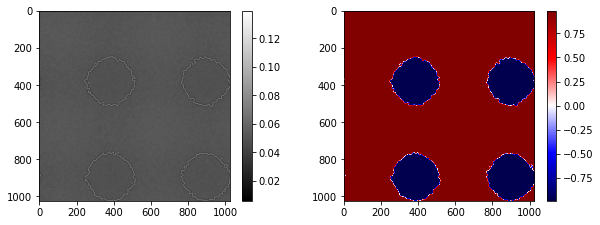

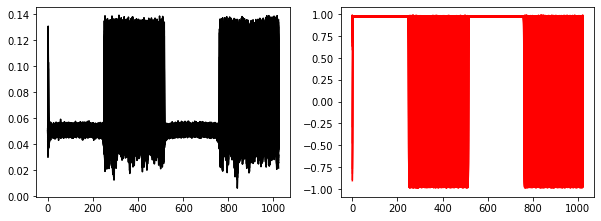

max_region_c: 0.13940991103320974 , max_region_s: 0.9869344864347177
min_region_c: 0.012203109056768528 , min_region_s: -0.990494707694249
amplitude_c: 0.06360340098822061 , amplitude_s: 0.9887145970644833
 
time_step= 7300
Tiempo CPU en segundos: 67328.34
c.mean = 0.0500 s.mean = 0.6141
c.min  = 0.0047  s.min = -0.9899
c.max  = 0.1396  s.max = 0.9880


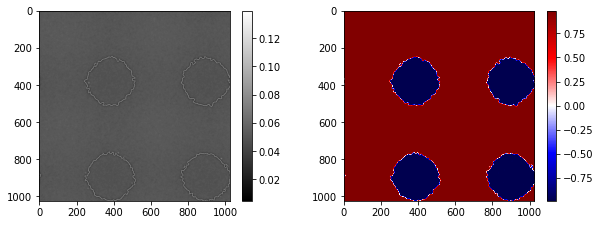

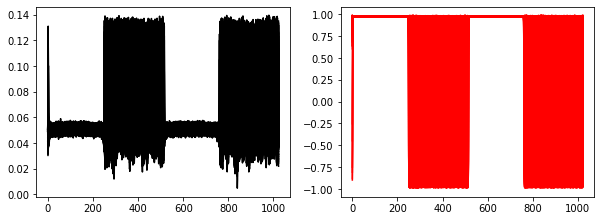

max_region_c: 0.13917625069833706 , max_region_s: 0.9868916441420322
min_region_c: 0.011832908348445465 , min_region_s: -0.9899132664339865
amplitude_c: 0.0636716711749458 , amplitude_s: 0.9884024552880093
 
time_step= 7400
Tiempo CPU en segundos: 68231.03
c.mean = 0.0500 s.mean = 0.6141
c.min  = 0.0038  s.min = -0.9898
c.max  = 0.1405  s.max = 0.9880


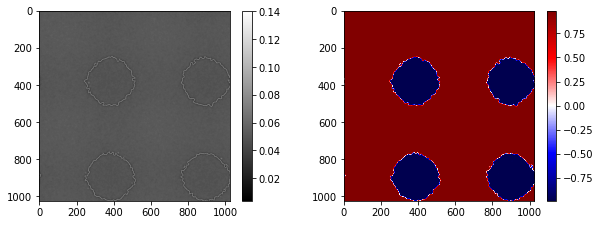

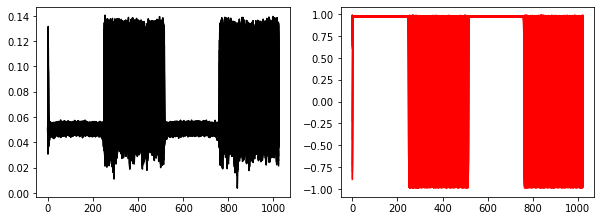

max_region_c: 0.13939475465053586 , max_region_s: 0.9879839219943218
min_region_c: 0.011034804625764543 , min_region_s: -0.9898035777046228
amplitude_c: 0.06417997501238566 , amplitude_s: 0.9888937498494723
 
time_step= 7500
Tiempo CPU en segundos: 69128.48
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0027  s.min = -0.9895
c.max  = 0.1403  s.max = 0.9892


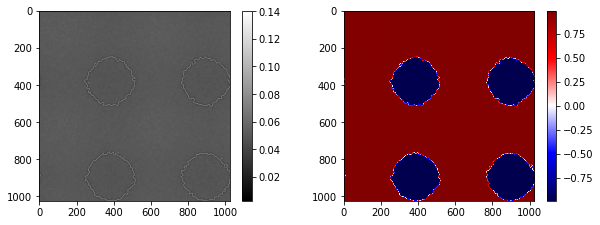

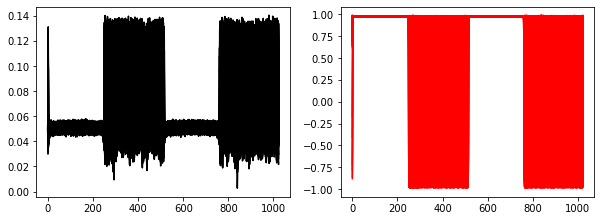

max_region_c: 0.13954438046162593 , max_region_s: 0.987023534749476
min_region_c: 0.00934504797431553 , min_region_s: -0.9894667302710649
amplitude_c: 0.0650996662436552 , amplitude_s: 0.9882451325102705
 
time_step= 7600
Tiempo CPU en segundos: 70035.82
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0018  s.min = -0.9905
c.max  = 0.1408  s.max = 0.9891


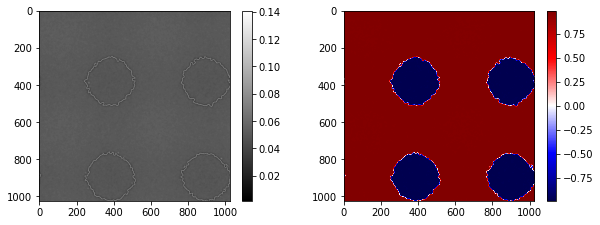

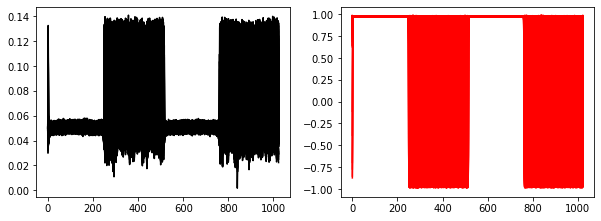

max_region_c: 0.1407765956522894 , max_region_s: 0.9866075000816912
min_region_c: 0.010927333451901137 , min_region_s: -0.9904720007985359
amplitude_c: 0.06492463110019413 , amplitude_s: 0.9885397504401136
 
time_step= 7700
Tiempo CPU en segundos: 70970.62
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0011  s.min = -0.9895
c.max  = 0.1404  s.max = 0.9882


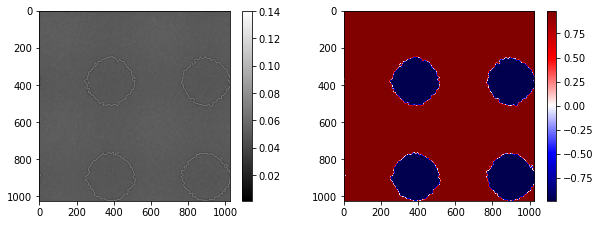

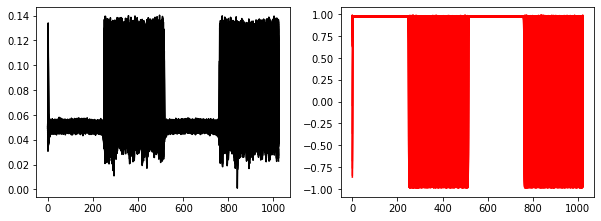

max_region_c: 0.140379598371172 , max_region_s: 0.9865010424057181
min_region_c: 0.01097977721274567 , min_region_s: -0.9895367070380735
amplitude_c: 0.06469991057921316 , amplitude_s: 0.9880188747218959
 
time_step= 7800
Tiempo CPU en segundos: 71895.64
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0015  s.min = -0.9901
c.max  = 0.1409  s.max = 0.9883


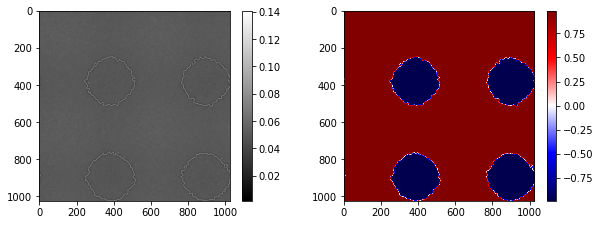

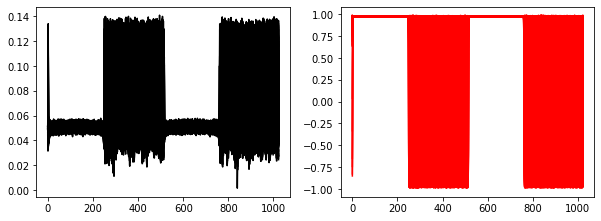

max_region_c: 0.14094265486764096 , max_region_s: 0.9866435535864124
min_region_c: 0.011244828197864057 , min_region_s: -0.9900989664195401
amplitude_c: 0.06484891333488846 , amplitude_s: 0.9883712600029763
 
time_step= 7900
Tiempo CPU en segundos: 72828.02
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0027  s.min = -0.9904
c.max  = 0.1414  s.max = 0.9886


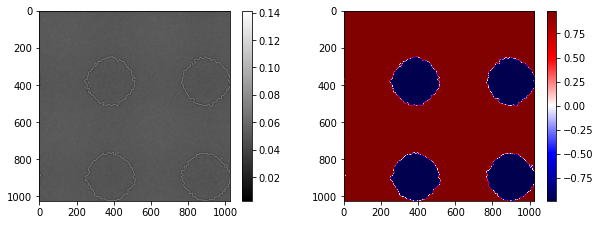

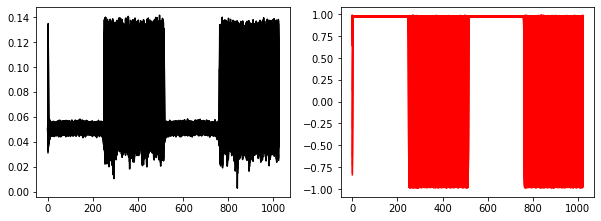

max_region_c: 0.14144806443334595 , max_region_s: 0.9873932293560321
min_region_c: 0.01032771513543586 , min_region_s: -0.9903642906396731
amplitude_c: 0.06556017464895504 , amplitude_s: 0.9888787599978526
 
time_step= 8000
Tiempo CPU en segundos: 73739.44
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0057  s.min = -0.9900
c.max  = 0.1410  s.max = 0.9883


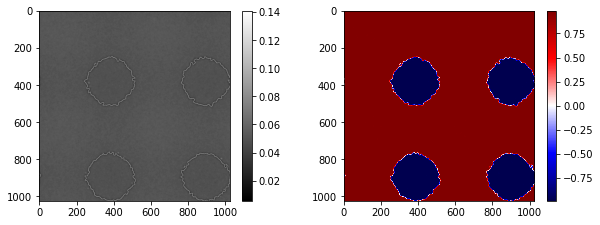

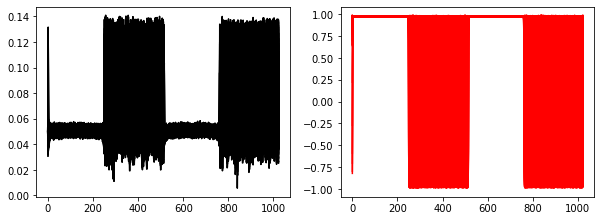

max_region_c: 0.14096627642009077 , max_region_s: 0.9868421469622497
min_region_c: 0.011105501510713638 , min_region_s: -0.9899914657250606
amplitude_c: 0.06493038745468857 , amplitude_s: 0.9884168063436551
 
time_step= 8100
Tiempo CPU en segundos: 74646.23
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0073  s.min = -0.9898
c.max  = 0.1409  s.max = 0.9881


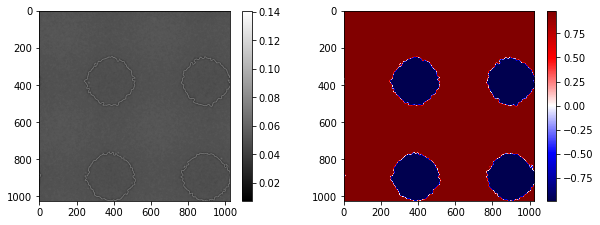

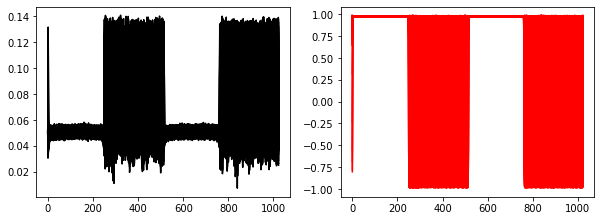

max_region_c: 0.14090907474886696 , max_region_s: 0.9871591844447201
min_region_c: 0.01097921675727023 , min_region_s: -0.9897765429611259
amplitude_c: 0.06496492899579837 , amplitude_s: 0.9884678637029229
 
time_step= 8200
Tiempo CPU en segundos: 75570.68
c.mean = 0.0500 s.mean = 0.6142
c.min  = 0.0103  s.min = -0.9906
c.max  = 0.1409  s.max = 0.9884


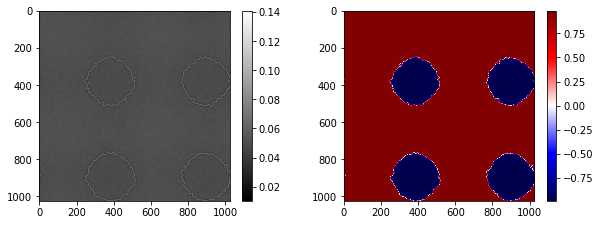

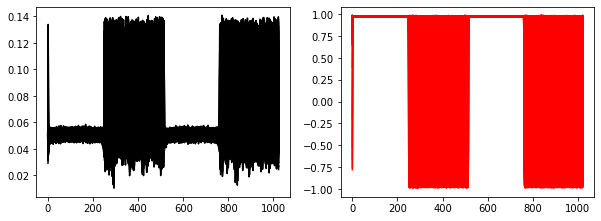

max_region_c: 0.1406856912334914 , max_region_s: 0.9860845945115221
min_region_c: 0.010340342065168233 , min_region_s: -0.9905764239189184
amplitude_c: 0.06517267458416158 , amplitude_s: 0.9883305092152203
 
time_step= 8300
Tiempo CPU en segundos: 76506.19
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0107  s.min = -0.9898
c.max  = 0.1416  s.max = 0.9889


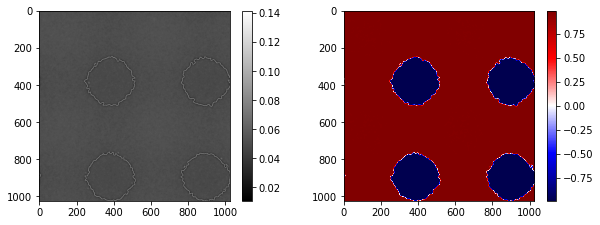

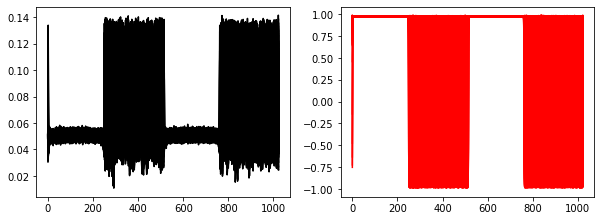

max_region_c: 0.1410501052621731 , max_region_s: 0.9870071585278404
min_region_c: 0.010710360887389697 , min_region_s: -0.9897941347540081
amplitude_c: 0.0651698721873917 , amplitude_s: 0.9884006466409243
 
time_step= 8400
Tiempo CPU en segundos: 77430.64
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0104  s.min = -0.9900
c.max  = 0.1416  s.max = 0.9882


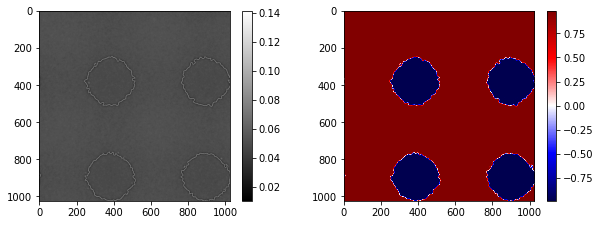

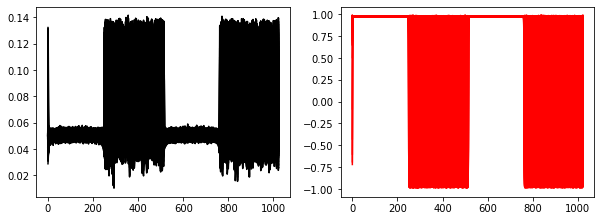

max_region_c: 0.14161032294630696 , max_region_s: 0.9865266937302788
min_region_c: 0.010375555561305743 , min_region_s: -0.9899910194285289
amplitude_c: 0.06561738369250061 , amplitude_s: 0.9882588565794038
 
time_step= 8500
Tiempo CPU en segundos: 78323.05
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0113  s.min = -0.9910
c.max  = 0.1420  s.max = 0.9884


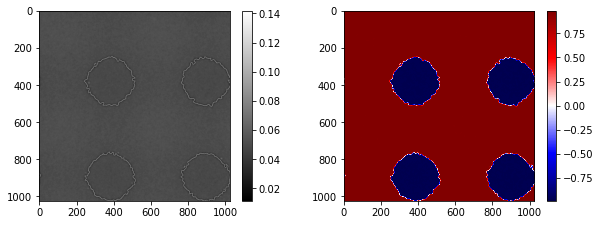

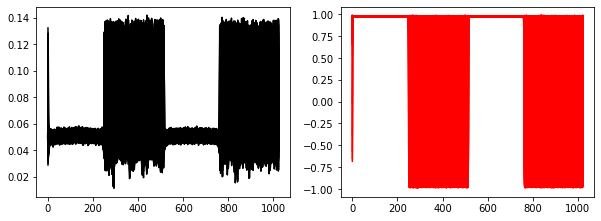

max_region_c: 0.14198201117498113 , max_region_s: 0.9865133420027568
min_region_c: 0.011307894804371051 , min_region_s: -0.9909928400537459
amplitude_c: 0.06533705818530504 , amplitude_s: 0.9887530910282514
 
time_step= 8600
Tiempo CPU en segundos: 79231.16
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0107  s.min = -0.9903
c.max  = 0.1417  s.max = 0.9883


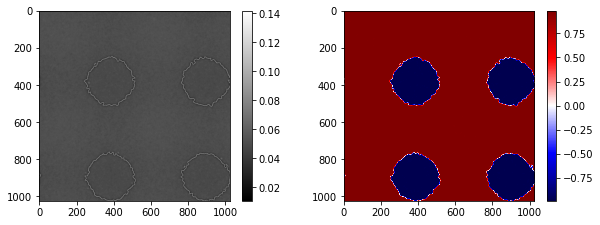

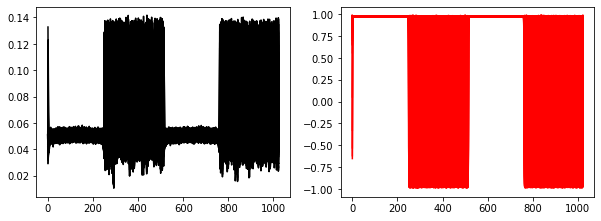

max_region_c: 0.14171197922719822 , max_region_s: 0.9865158144340379
min_region_c: 0.010662589081152302 , min_region_s: -0.9903273904532963
amplitude_c: 0.06552469507302296 , amplitude_s: 0.9884216024436672
 
time_step= 8700
Tiempo CPU en segundos: 80169.69
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0106  s.min = -0.9894
c.max  = 0.1410  s.max = 0.9882


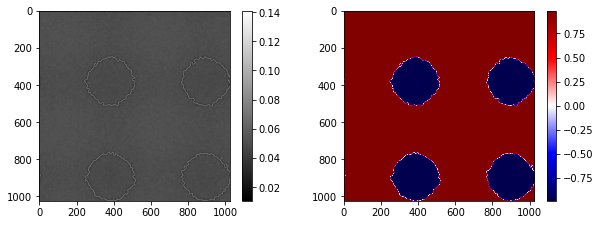

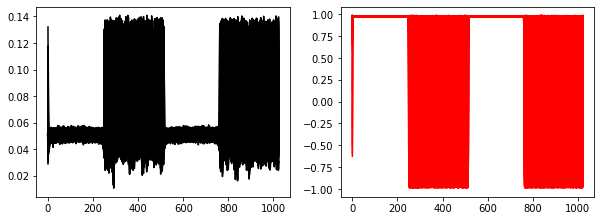

max_region_c: 0.14095706386138612 , max_region_s: 0.9868769846581962
min_region_c: 0.010613224256005525 , min_region_s: -0.9894234764048248
amplitude_c: 0.0651719198026903 , amplitude_s: 0.9881502305315104
 
time_step= 8800
Tiempo CPU en segundos: 81075.91
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0107  s.min = -0.9901
c.max  = 0.1416  s.max = 0.9882


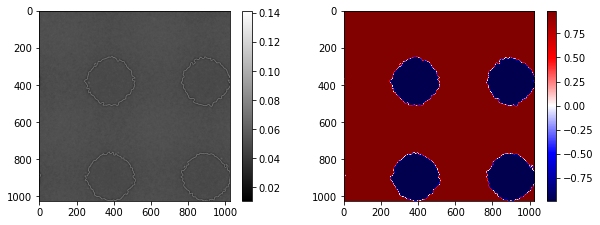

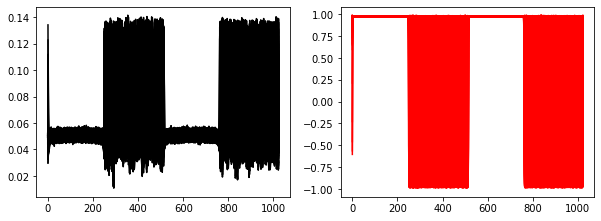

max_region_c: 0.14159075364097115 , max_region_s: 0.9867959899536123
min_region_c: 0.010725234343328395 , min_region_s: -0.9900980144460647
amplitude_c: 0.06543275964882138 , amplitude_s: 0.9884470021998385
 
time_step= 8900
Tiempo CPU en segundos: 81976.28
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0108  s.min = -0.9900
c.max  = 0.1418  s.max = 0.9882


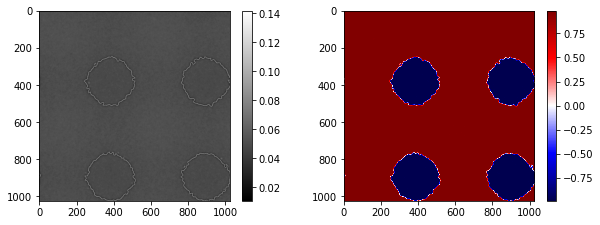

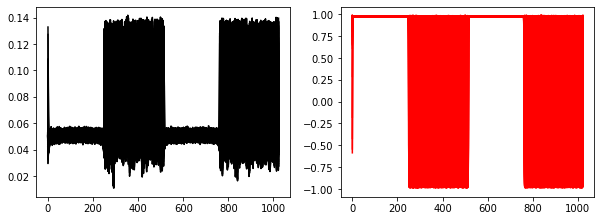

max_region_c: 0.14178106155549752 , max_region_s: 0.9859219222925777
min_region_c: 0.010770594522509076 , min_region_s: -0.9900328661125034
amplitude_c: 0.06550523351649422 , amplitude_s: 0.9879773942025405
 
time_step= 9000
Tiempo CPU en segundos: 82916.32
c.mean = 0.0500 s.mean = 0.6143
c.min  = 0.0106  s.min = -0.9905
c.max  = 0.1417  s.max = 0.9886


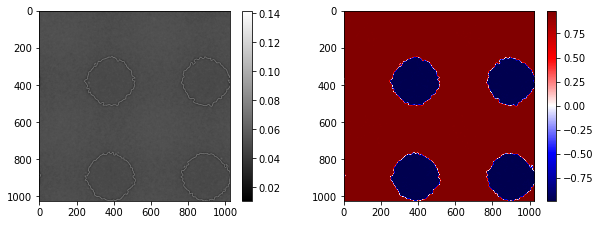

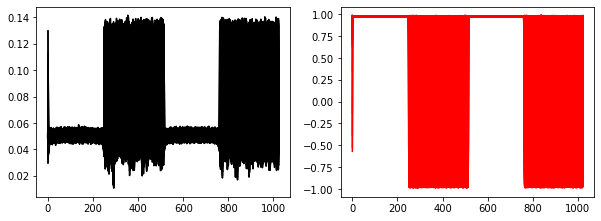

max_region_c: 0.14170434634929205 , max_region_s: 0.986225817498529
min_region_c: 0.010646331574592539 , min_region_s: -0.9905197762088973
amplitude_c: 0.06552900738734975 , amplitude_s: 0.9883727968537132
 
time_step= 9100
Tiempo CPU en segundos: 83845.62
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0109  s.min = -0.9898
c.max  = 0.1419  s.max = 0.9883


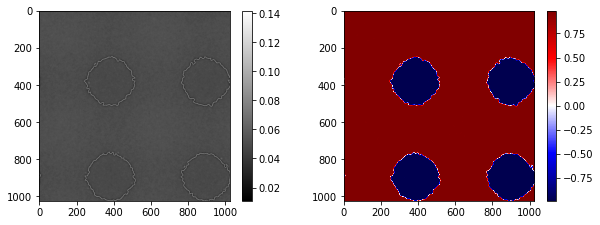

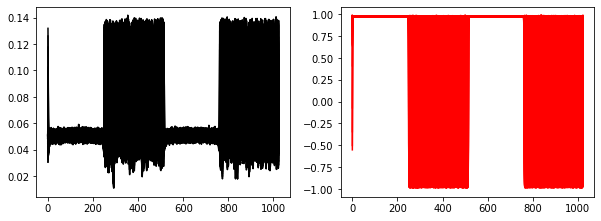

max_region_c: 0.1418969419009545 , max_region_s: 0.9862993111848608
min_region_c: 0.010850897092292736 , min_region_s: -0.9897535512159191
amplitude_c: 0.06552302240433089 , amplitude_s: 0.9880264312003899
 
time_step= 9200
Tiempo CPU en segundos: 84761.44
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0104  s.min = -0.9903
c.max  = 0.1417  s.max = 0.9881


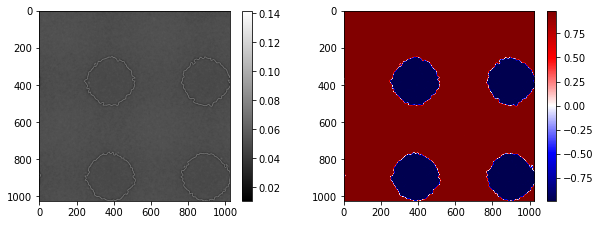

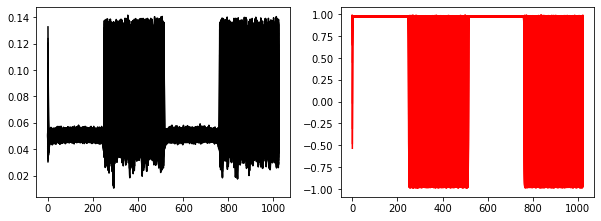

max_region_c: 0.14166023315148898 , max_region_s: 0.9857373660884319
min_region_c: 0.01044475107330299 , min_region_s: -0.9902728282311798
amplitude_c: 0.065607741039093 , amplitude_s: 0.9880050971598058
 
time_step= 9300
Tiempo CPU en segundos: 85696.05
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0105  s.min = -0.9897
c.max  = 0.1418  s.max = 0.9883


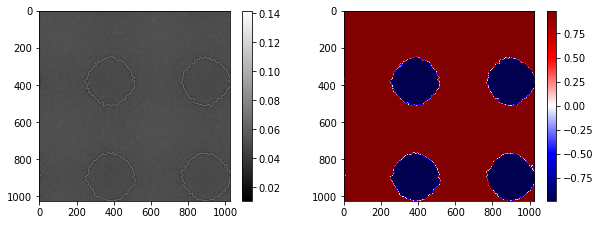

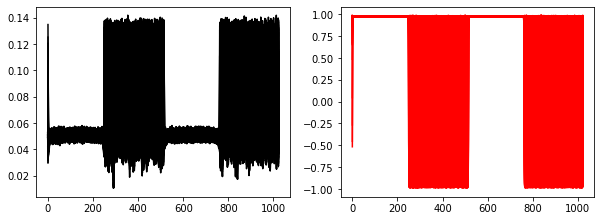

max_region_c: 0.141837064928524 , max_region_s: 0.9855170054610525
min_region_c: 0.01045042587693431 , min_region_s: -0.9897321365451573
amplitude_c: 0.06569331952579484 , amplitude_s: 0.9876245710031049
 
time_step= 9400
Tiempo CPU en segundos: 86645.19
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0102  s.min = -0.9886
c.max  = 0.1414  s.max = 0.9887


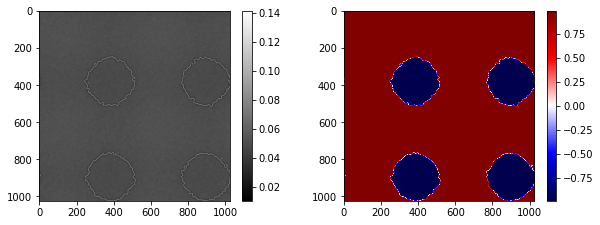

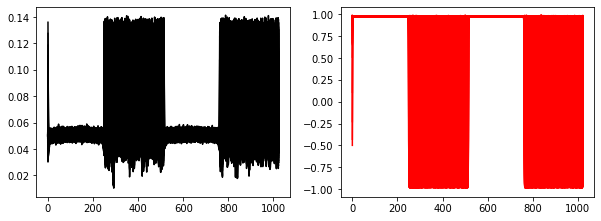

max_region_c: 0.14093322937973968 , max_region_s: 0.9859402848096273
min_region_c: 0.010238995806591027 , min_region_s: -0.9886097601276044
amplitude_c: 0.06534711678657433 , amplitude_s: 0.9872750224686158
 
time_step= 9500
Tiempo CPU en segundos: 87573.16
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0083  s.min = -0.9888
c.max  = 0.1416  s.max = 0.9885


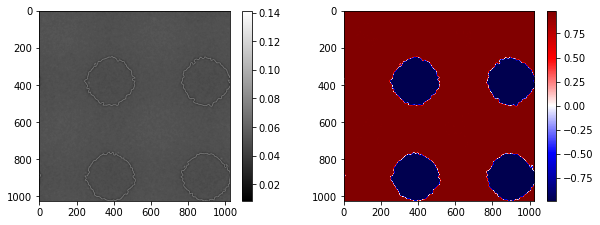

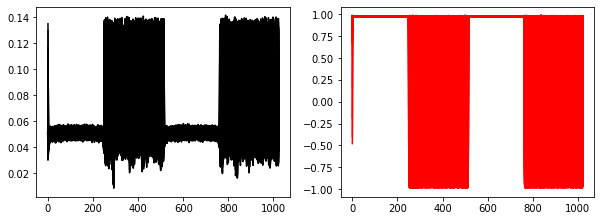

max_region_c: 0.14086638161949258 , max_region_s: 0.9858140020758674
min_region_c: 0.008346349725226932 , min_region_s: -0.988813445422322
amplitude_c: 0.06626001594713282 , amplitude_s: 0.9873137237490948
 
time_step= 9600
Tiempo CPU en segundos: 88501.59
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0077  s.min = -0.9880
c.max  = 0.1415  s.max = 0.9885


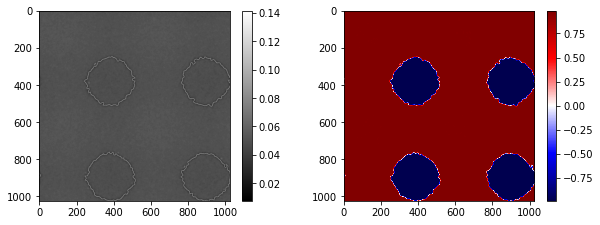

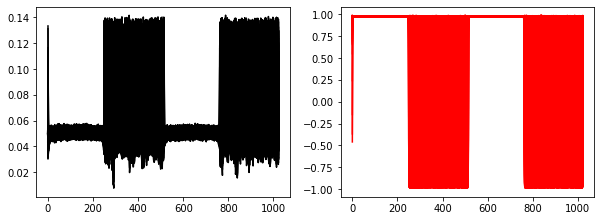

max_region_c: 0.14143197295662965 , max_region_s: 0.9859043678623123
min_region_c: 0.007684243806677238 , min_region_s: -0.9879504005364049
amplitude_c: 0.06687386457497621 , amplitude_s: 0.9869273841993587
 
time_step= 9700
Tiempo CPU en segundos: 89417.62
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0074  s.min = -0.9879
c.max  = 0.1418  s.max = 0.9890


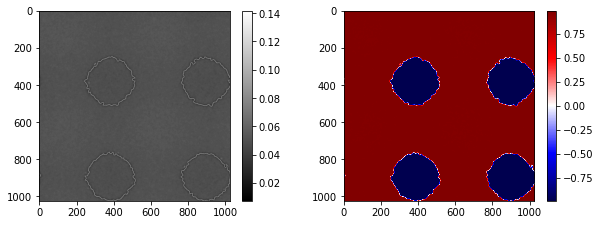

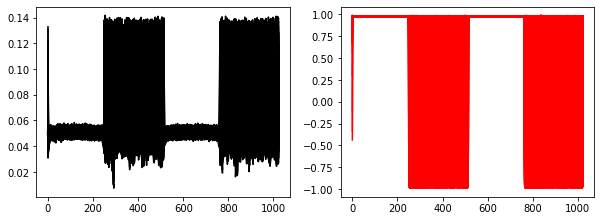

max_region_c: 0.1409502955668976 , max_region_s: 0.9861184938334765
min_region_c: 0.007350816829790599 , min_region_s: -0.9878836324306329
amplitude_c: 0.06679973936855349 , amplitude_s: 0.9870010631320547
 
time_step= 9800
Tiempo CPU en segundos: 90327.81
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0066  s.min = -0.9889
c.max  = 0.1419  s.max = 0.9892


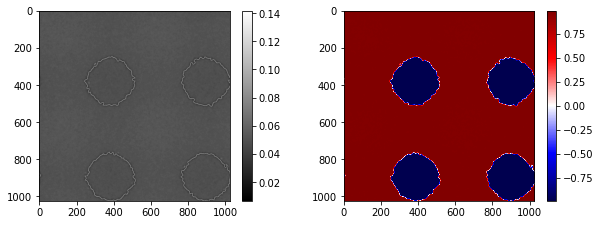

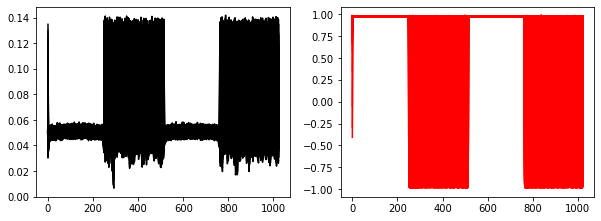

max_region_c: 0.14121215599762066 , max_region_s: 0.9867864963851511
min_region_c: 0.006609884017753867 , min_region_s: -0.9888681787816281
amplitude_c: 0.0673011359899334 , amplitude_s: 0.9878273375833897
 
time_step= 9900
Tiempo CPU en segundos: 91248.14
c.mean = 0.0500 s.mean = 0.6144
c.min  = 0.0058  s.min = -0.9893
c.max  = 0.1417  s.max = 0.9881


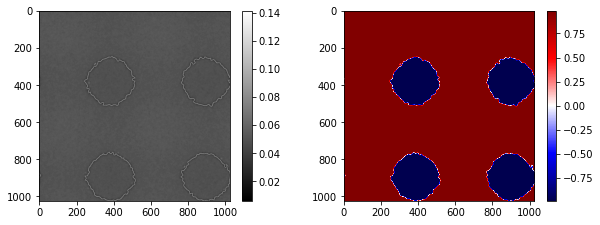

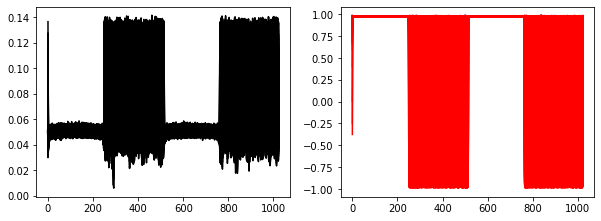

max_region_c: 0.14168876192191246 , max_region_s: 0.9860279822307689
min_region_c: 0.005817610971640133 , min_region_s: -0.9893248210294673
amplitude_c: 0.06793557547513616 , amplitude_s: 0.987676401630118
 
time_step= 10000
Tiempo CPU en segundos: 92169.14
c.mean = 0.0500 s.mean = 0.6145
c.min  = 0.0068  s.min = -0.9875
c.max  = 0.1420  s.max = 0.9881


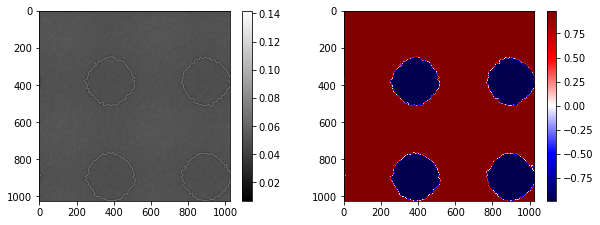

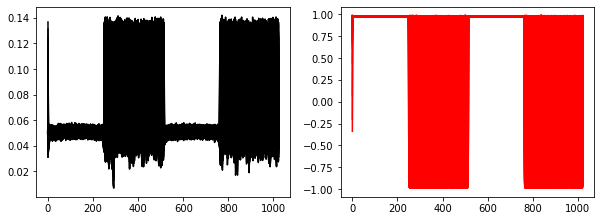

max_region_c: 0.1415001288541011 , max_region_s: 0.9864750341130881
min_region_c: 0.006806543203950413 , min_region_s: -0.9875263863005173
amplitude_c: 0.06734679282507534 , amplitude_s: 0.9870007102068027
 
time_step= 10100
Tiempo CPU en segundos: 93108.20
c.mean = 0.0500 s.mean = 0.6145
c.min  = 0.0069  s.min = -0.9869
c.max  = 0.1419  s.max = 0.9885


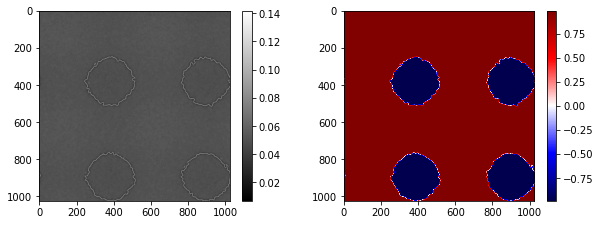

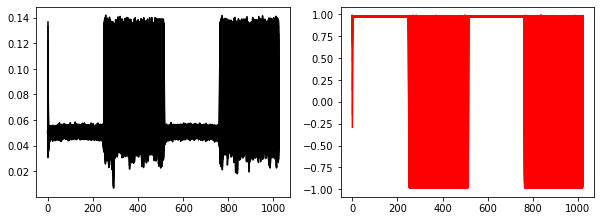

max_region_c: 0.1419072226763534 , max_region_s: 0.9868875426755829
min_region_c: 0.006886312548386048 , min_region_s: -0.9869432333329655
amplitude_c: 0.06751045506398368 , amplitude_s: 0.9869153880042743
Program end.


In [19]:
print("Program will run nTimeSteps: ", nTimeSteps)
print("Print results each print_period steps: ", print_period)
print("Total simulation time at the end:", T_total)

print("Temperature: = {:.3f}" .format(T))
print("SW range lambda  = {:.3f}" .format(1+Lambda/10.0))
print("wavenumber k = {:.3f}" .format(k))
print("wavelength = {:.3f}" .format(lambd))

# Apply periodic boundary conditions to fields s & c
for x in (s,c):
    PBC(x)

# declare empty arrays vacíos 
time_step = []
amplitude_c_step = [] 
amplitude_s_step=[]

#define el tiempo inicial de corrida, será igual al tiempo real de comienzo
t0 = time.time()

# Save initial state
#save_fields(s, c, 0, block)


# Solve the dynamics
for i in range(1,nTimeSteps+1):
   
    solve_dynamics(c,phi,Lambda,T,alphap,s,N,dx,dt,i,R,r)
    #save_fields(s, c, i, block)
        
    if( (i % print_period) == 0 ):
        print(" ")
        print("time_step=", i) 
        
        tf = time.time()
        print("Tiempo CPU en segundos: {:.2f}" .format(tf-t0))

            
        print("c.mean = {:.4f} s.mean = {:.4f}" .format(c.mean(), s.mean()))
        print("c.min  = {:.4f}  s.min = {:.4f}" .format(c.min(), s.min()))
        print("c.max  = {:.4f}  s.max = {:.4f}" .format(c.max(), s.max()))

        plot_fields_in_2D(s,c,i)
        plot_fields_in_1D(s,c,i)
        
        
#    Save to disk the pictures for the NP concentration and LC order parameter

#    plt.imshow(c, cmap=plt.cm.gray)
#    plt.colorbar()
#    plt.savefig('imagen{}.png'.format(i))
#    plt.show()


#    plt.imshow(s, cmap=plt.cm.seismic)
#    plt.colorbar()
#    plt.savefig('imagen{}.png'.format(i))
#    plt.show()
        
        
        # Measure the amplitude of the perturbations in c and s over time
        # Sample the central region  
        region_min = N//4         # Careful, // means integer division
        region_max = N//4 + N//2  # Again, // means integer division
    
        region_c = c[region_min:region_max]
        region_s=  s[region_min:region_max]
    
        # Obtain min and max for c and s in that region
        max_region_c= region_c.max()
        max_region_s= region_s.max()
        min_region_c= region_c.min()
        min_region_s= region_s.min()
    
        # Amplitude for each field equals half the range between the maximum and minimum values
        amplitude_c= (max_region_c-min_region_c)/2
        amplitude_s= (max_region_s-min_region_s)/2
    
        # Print out statistics 
        print("max_region_c:",max_region_c, ", max_region_s:",max_region_s )    
        print("min_region_c:",min_region_c, ", min_region_s:",min_region_s,)
        print("amplitude_c:",amplitude_c,   ", amplitude_s:",amplitude_s)

        # Collect amplitudes and corresponding time steps into arrays
        time_step.append(float(i))
        amplitude_c_step.append(amplitude_c)
        amplitude_s_step.append(amplitude_s)


print("Program end.")    
# End of main simulation program    

# Analysis of amplitude vs time

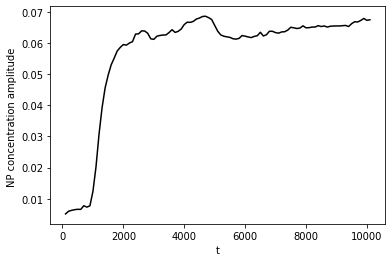

In [20]:
# Plot amplitude of NP concentration c vs time_step
plt.plot(time_step, amplitude_c_step, "k-")
plt.xlabel("t")
plt.ylabel("NP concentration amplitude ")
plt.savefig('amplitude_time_c.png')
plt.show()

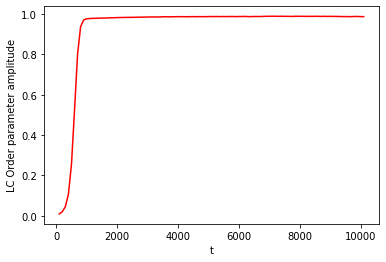

In [21]:
# Plot amplitude of LC order parameter s vs time_step
plt.plot(time_step, amplitude_s_step, "r-")
plt.xlabel("t")
plt.ylabel("LC Order parameter amplitude")
plt.savefig('amplitude_time_s.png')
plt.show()

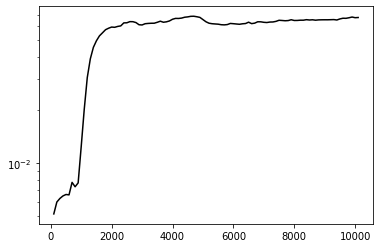

In [22]:
plt.semilogy(time_step, amplitude_c_step, "k-")
plt.savefig('amplitude_time_semilog_c.png')

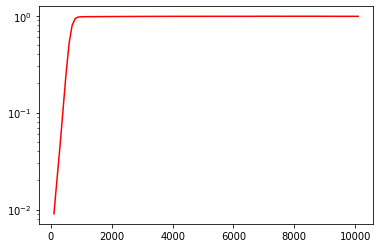

In [23]:
plt.semilogy(time_step, amplitude_s_step, "r-")
plt.savefig('amplitude_time_semilog_s.png')